# DS 6040: Bayes Final Project Code
## Stephanie Fissel, Jackie Fraley, Quinn Glovier
### Loading Packages

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

az.style.use('arviz-darkgrid')
plt.rcParams['figure.dpi'] = 300

random_seed = 444
cores = 4

### Loading in the data

In [2]:
week = pd.read_csv("week_approach_maskedID_timeseries.csv")
week

nr. sessions  nr. rest days  total kms  max km one day  \
0               5.0            2.0       22.2            16.4   
1               5.0            2.0       21.6            16.4   
2               5.0            2.0       21.6            16.4   
3               5.0            2.0       21.6            16.4   
4               6.0            1.0       39.2            17.6   
...             ...            ...        ...             ...   
42793           4.0            3.0       59.5            19.0   
42794           1.0            6.0        5.8             5.8   
42795           3.0            4.0       38.3            16.0   
42796           5.0            2.0       67.0            15.1   
42797           4.0            3.0       45.0            12.2   

       total km Z3-Z4-Z5-T1-T2  nr. tough sessions (effort in Z5, T1 or T2)  \
0                         11.8                                          1.0   
1                         11.7                                          1.0   
2                         11.7                                          1.0   
3                         11.7                                          1.0   
4                         18.9                                          1.0   
...                        ...                                          ...   
42793                      0.0                                          0.0   
42794                      0.0                                          0.0   
42795                      0.0                                          0.0   
42796                      0.0                                          0.0   
42797                      0.0                                          0.0   

       nr. days with interval session  total km Z3-4  max km Z3-4 one day  \
0                                 2.0           10.0                 10.0   
1                                 2.0           10.0                 10.0   
2                                 2.0           10.0                 10.0   
3                                 2.0           10.0                 10.0   
4                                 3.0           17.2                 10.0   
...                               ...            ...                  ...   
42793                             0.0            0.0                  0.0   
42794                             0.0            0.0                  0.0   
42795                             0.0            0.0                  0.0   
42796                             0.0            0.0                  0.0   
42797                             0.0            0.0                  0.0   

       total km Z5-T1-T2  ...  max training success.2  avg recovery.2  \
0                    0.6  ...                    0.00            0.18   
1                    0.5  ...                    0.00            0.18   
2                    0.5  ...                    0.00            0.17   
3                    0.5  ...                    0.00            0.18   
4                    0.5  ...                    0.00            0.17   
...                  ...  ...                     ...             ...   
42793                0.0  ...                    0.80            0.20   
42794                0.0  ...                    0.85            0.12   
42795                0.0  ...                    0.93            0.32   
42796                0.0  ...                    0.91            0.28   
42797                0.0  ...                    0.88            0.16   

       min recovery.2  max recovery.2  Athlete ID  injury  \
0                0.16            0.20           0       0   
1                0.16            0.20           0       0   
2                0.16            0.18           0       0   
3                0.16            0.18           0       0   
4                0.16            0.18           0       0   
...               ...             ...         ...     ...   
42793            0.12            0.26          7

### Exploratory Data Analysis (EDA)
#### Descriptive Statistics

In [3]:
week.describe()

nr. sessions  nr. rest days     total kms  max km one day  \
count  42798.000000   42798.000000  42798.000000    42798.000000   
mean       5.809337       1.874667     49.543911       14.009255   
std        2.484234       1.853287     36.715017        9.071678   
min        0.000000       0.000000      0.000000        0.000000   
25%        5.000000       1.000000     22.800000        9.000000   
50%        6.000000       1.000000     44.800000       13.400000   
75%        7.000000       3.000000     70.100000       18.300000   
max       14.000000       7.000000    242.000000      131.000000   

       total km Z3-Z4-Z5-T1-T2  nr. tough sessions (effort in Z5, T1 or T2)  \
count             42798.000000                                 42798.000000   
mean                  9.433621                                     0.930184   
std                   8.887120                                     1.040631   
min                   0.000000                                     0.000000   
25%                   1.000000                                     0.000000   
50%                   8.000000                                     1.000000   
75%                  14.600000                                     2.000000   
max                 100.000000                                     6.000000   

       nr. days with interval session  total km Z3-4  max km Z3-4 one day  \
count                    42798.000000   42798.000000         42798.000000   
mean                         1.672531       4.859398             3.456888   
std                          1.263528       6.984670             4.577423   
min                          0.000000       0.000000             0.000000   
25%                          0.000000       0.000000             0.000000   
50%                          2.000000       0.000000             0.000000   
75%                          3.000000       8.000000             6.300000   
max                          7.000000      79.800000            75.000000   

       total km Z5-T1-T2  ...  max training success.2  avg recovery.2  \
count       42798.000000  ...            42798.000000    42798.000000   
mean            4.063970  ...                0.525709        0.255089   
std             5.645305  ...                0.390604        0.153214   
min             0.000000  ...                0.000000        0.000000   
25%             0.000000  ...                0.000000        0.150000   
50%             1.500000  ...                0.730000        0.220000   
75%             6.300000  ...                0.840000        0.360000   
max            80.000000  ...                1.000000        0.900000   

       min recovery.2  max recovery.2    Athlete ID        injury  \
count    42798.000000    42798.000000  42798.000000  42798.000000   
mean         0.184927        0.343522     34.538249      0.013435   
std          0.127996        0.219536     19.020826      0.115130   
min          0.000000        0.000000      0.000000      0.000000   
25%          0.110000        0.170000     20.000000      0.000000   
50%          0.160000        0.310000     34.000000      0.000000   
75%          0.240000        0.520000     50.000000      0.000000   
max          0.900000        1.000000     73.000000      1.000000   

       rel total kms week 0_1  rel total kms week 0_2  rel total kms week 1_2  \
count            4.279800e+04            4.279800e+04            4.279800e+04   
mean             4.408628e+05            9.014685e+05            4.803623e+05   
std              4.328234e+06            6.945503e+06            4.656806e+06   
min              0.000000e+00            0.000000e+00            0.000000e+00   
25%              6.955245e-01            6.723968e-01            6.923077e-01   
50%              9.891862e-01            1.001431e+00            9.897523e-01   
75%              1.320515e+00            1.422171e+00            1.327586e+00   
max              2.096000e+08            2.176000e+08       

#### Data Information

In [4]:
week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 72 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   nr. sessions                                   42798 non-null  float64
 1   nr. rest days                                  42798 non-null  float64
 2   total kms                                      42798 non-null  float64
 3   max km one day                                 42798 non-null  float64
 4   total km Z3-Z4-Z5-T1-T2                        42798 non-null  float64
 5   nr. tough sessions (effort in Z5, T1 or T2)    42798 non-null  float64
 6   nr. days with interval session                 42798 non-null  float64
 7   total km Z3-4                                  42798 non-null  float64
 8   max km Z3-4 one day                            42798 non-null  float64
 9   total km Z5-T1-T2                              427

#### Correlation Analysis

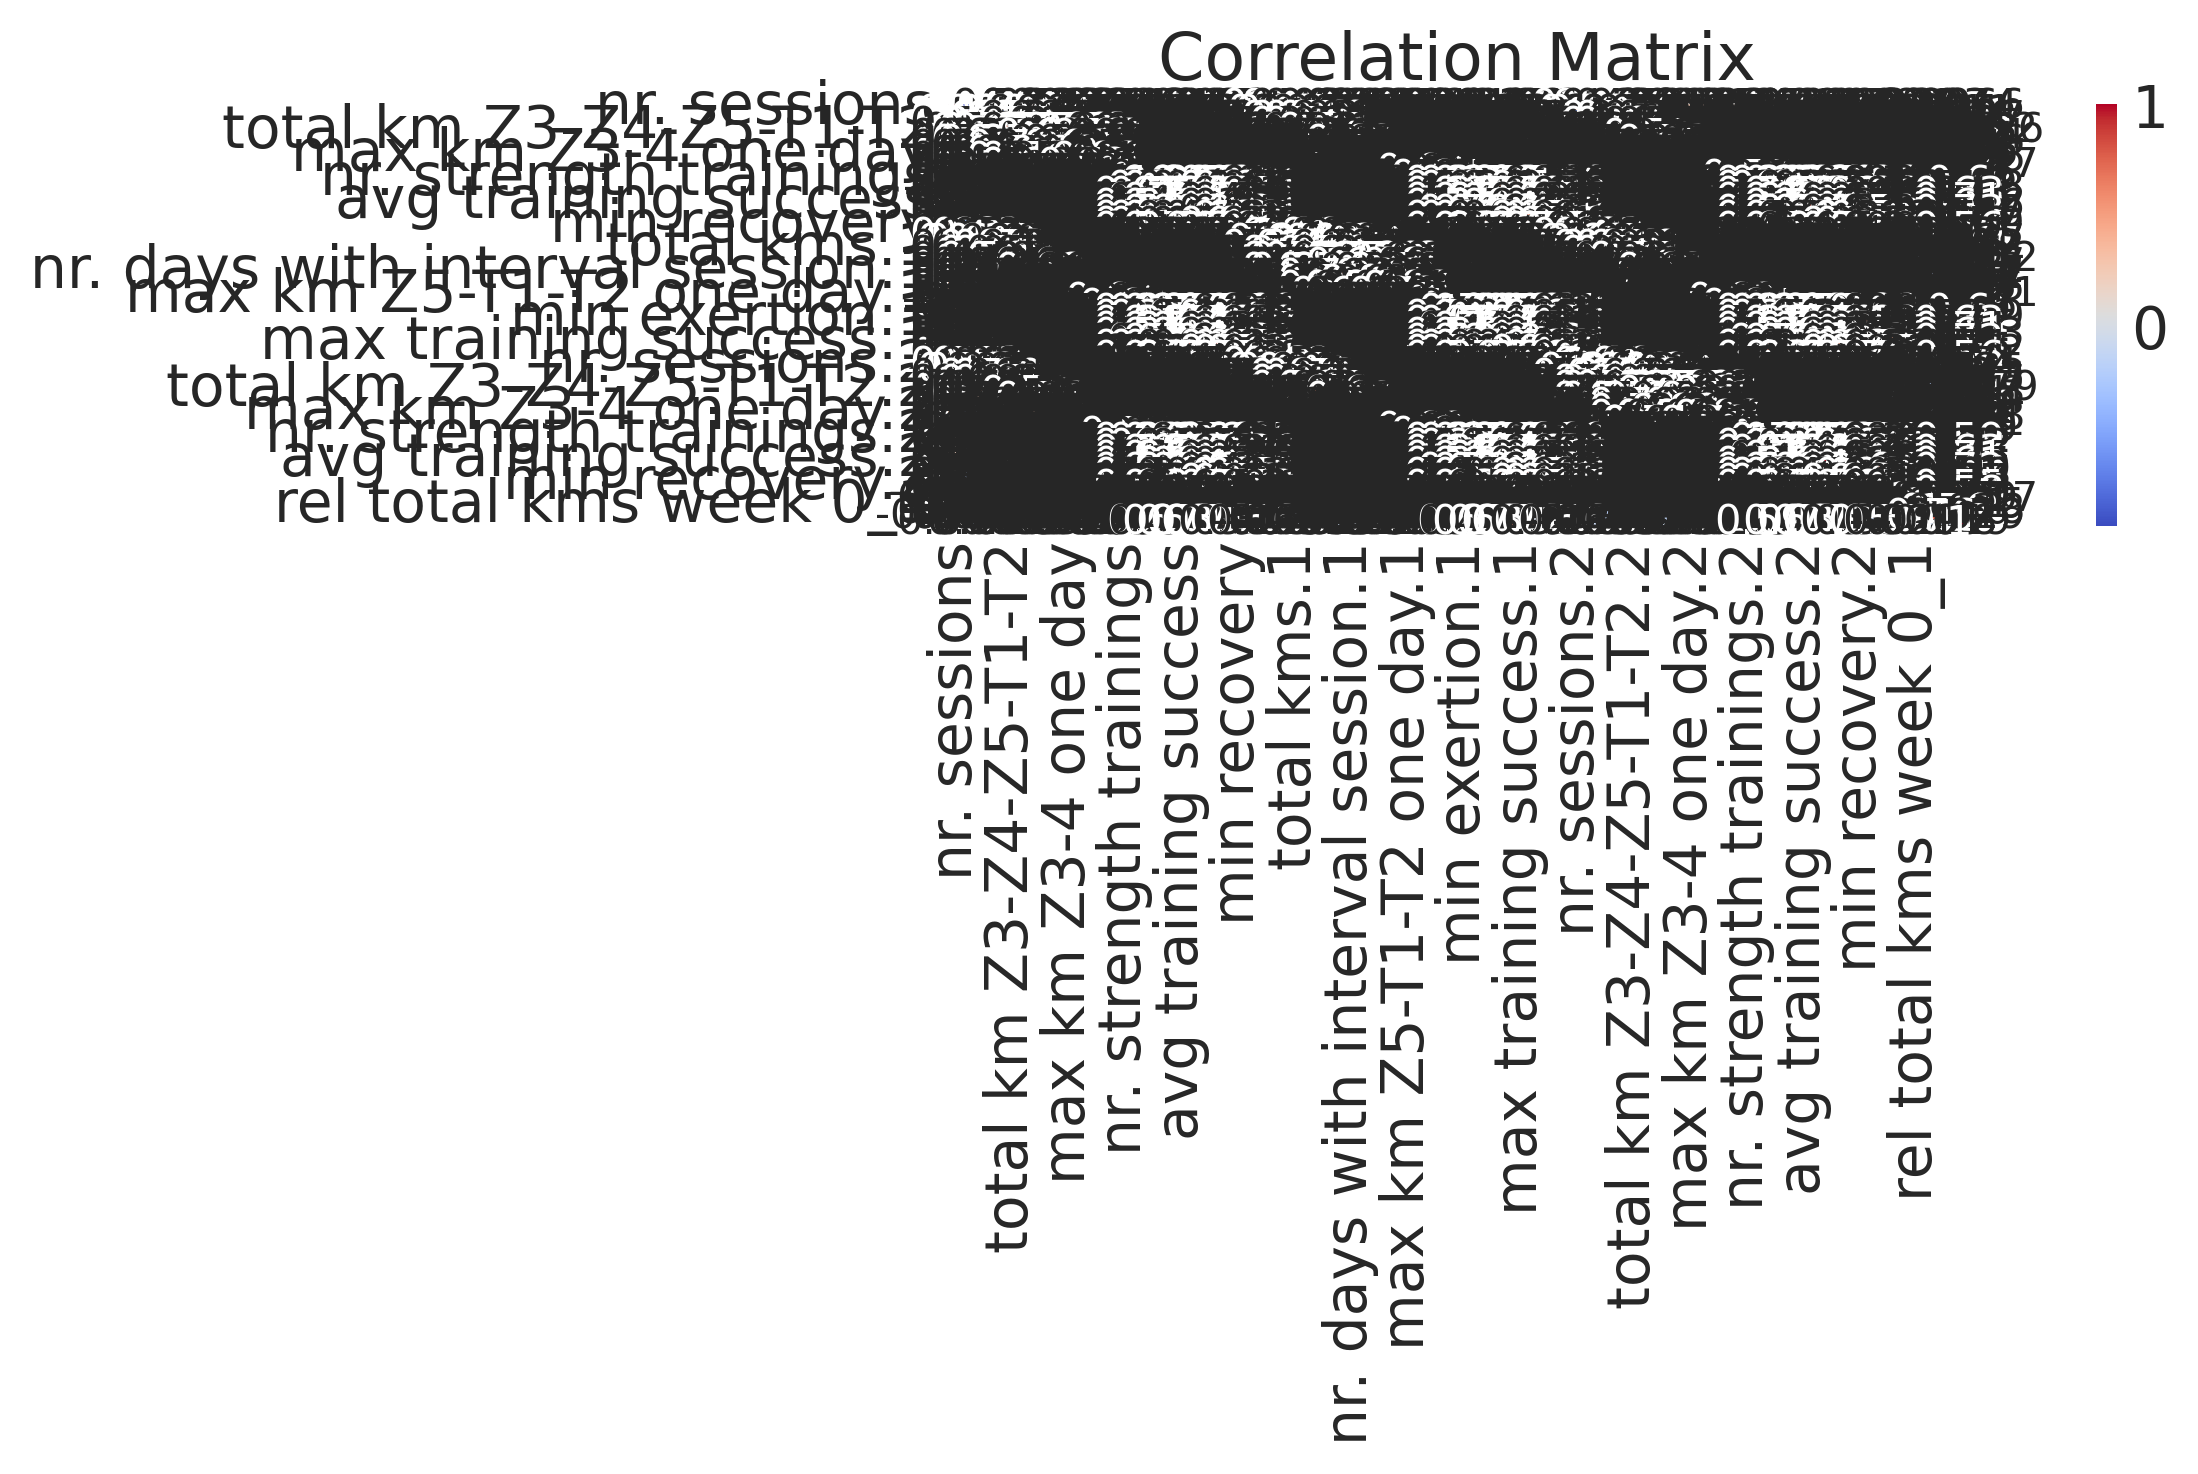

In [5]:
correlation_matrix = week.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

#### Injury Distribution

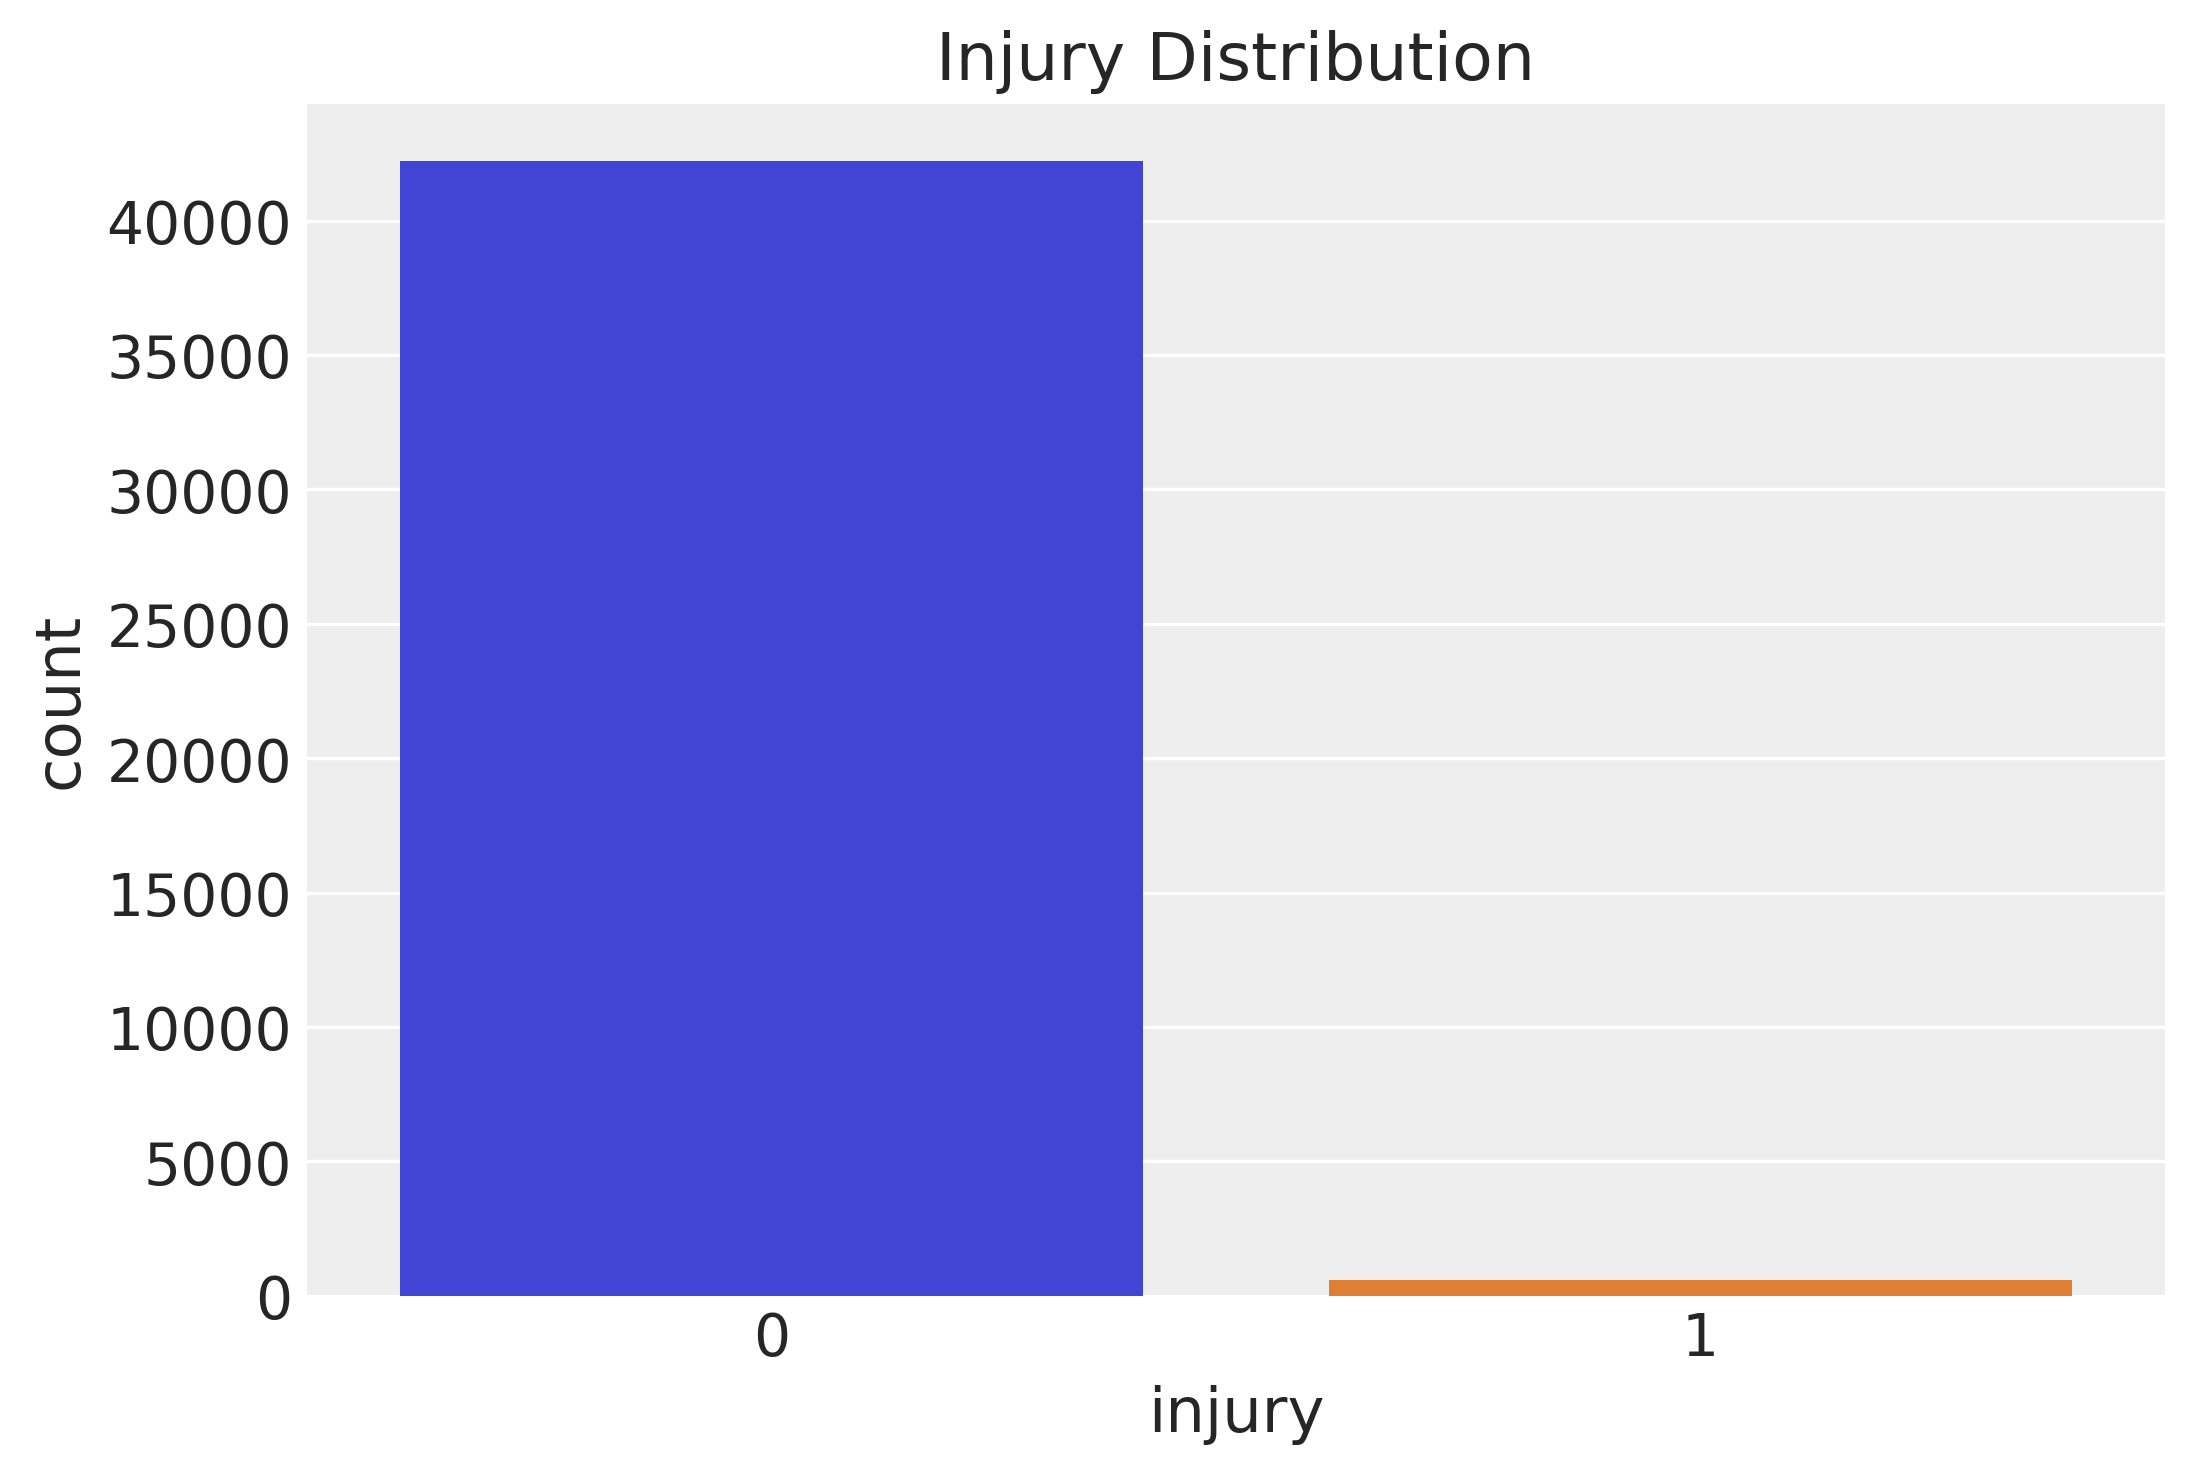

In [6]:
sns.countplot(x='injury', data = week)
plt.title("Injury Distribution")
plt.show()

#### Histogram of maximum kilometers ran per day by injury

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

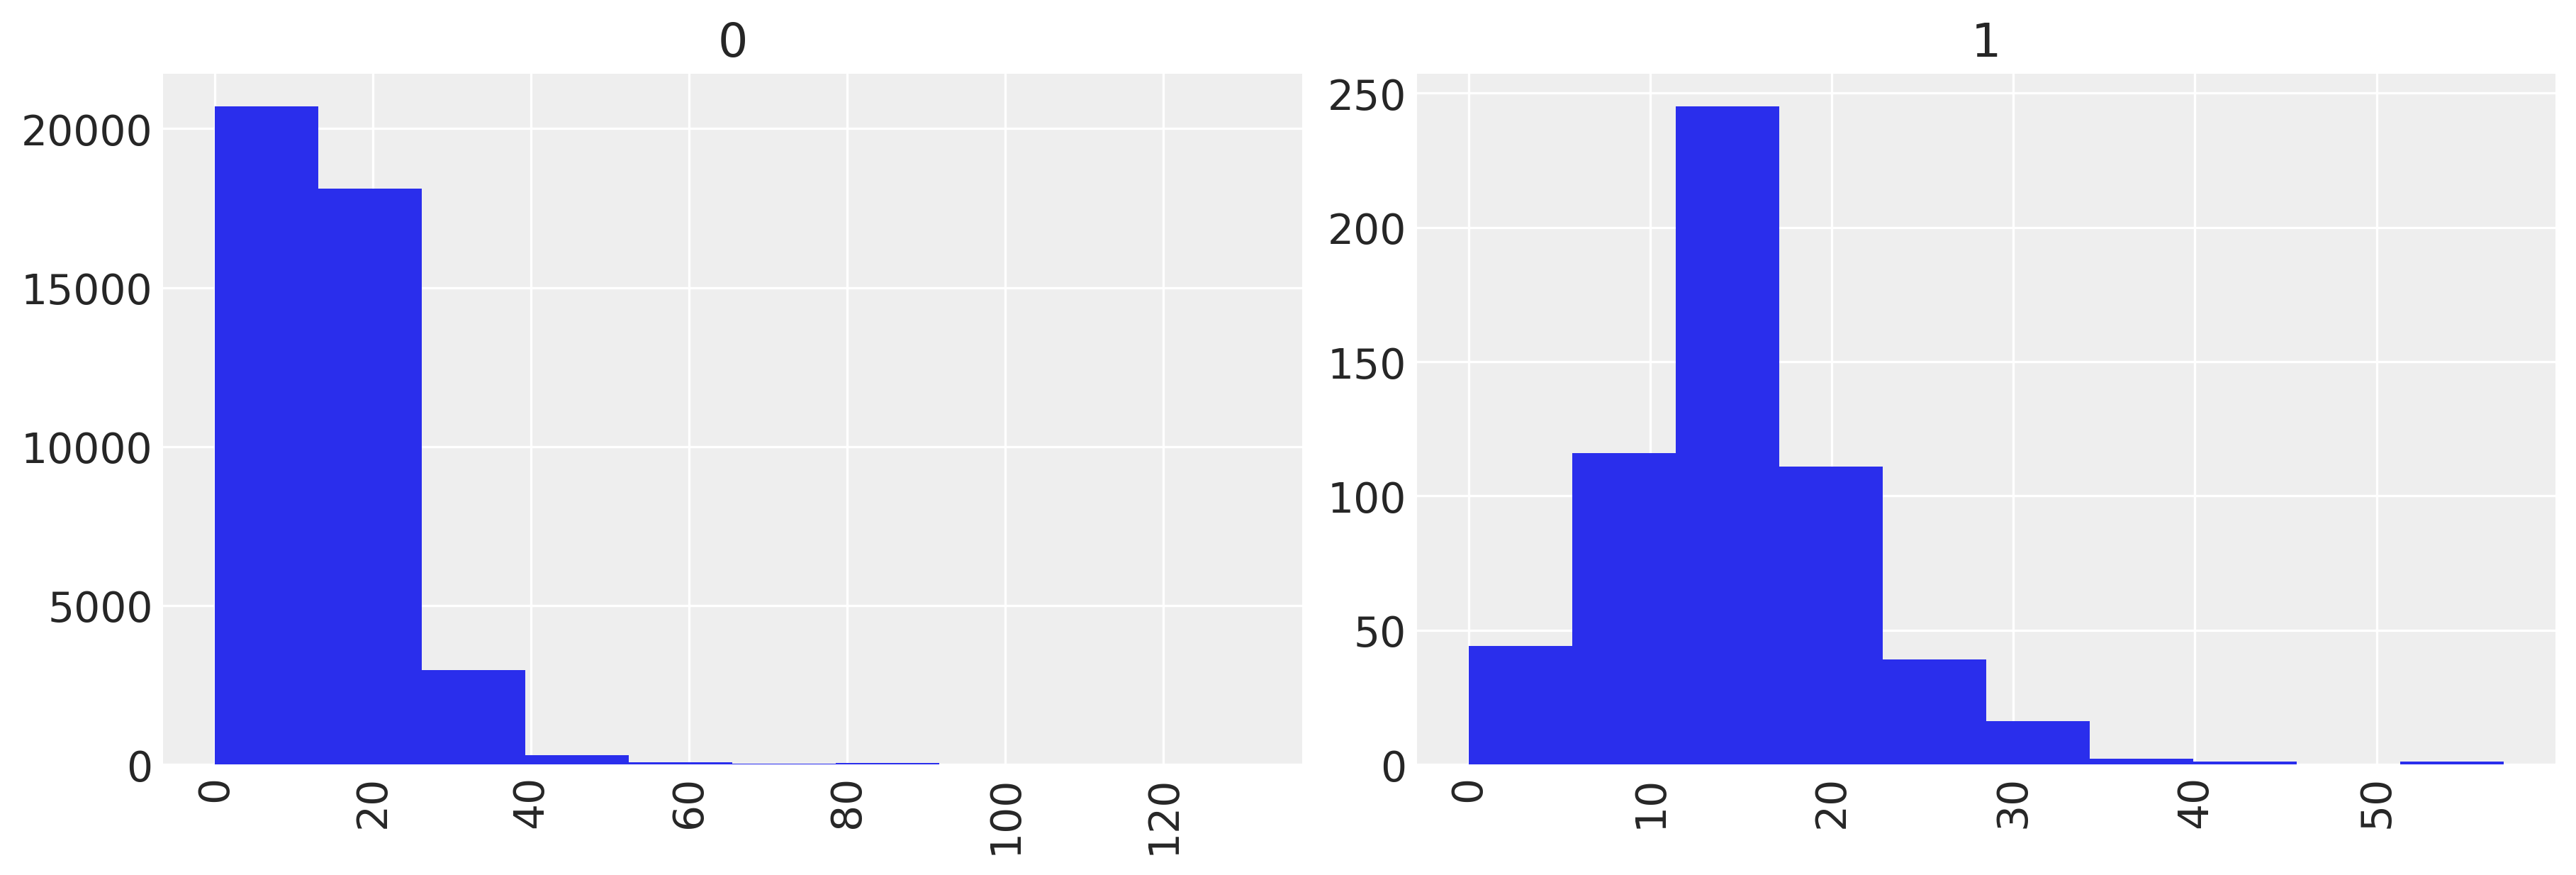

In [7]:
week.hist("max km one day", by="injury", figsize=(12, 4))

#### Distribution of Training Parameters

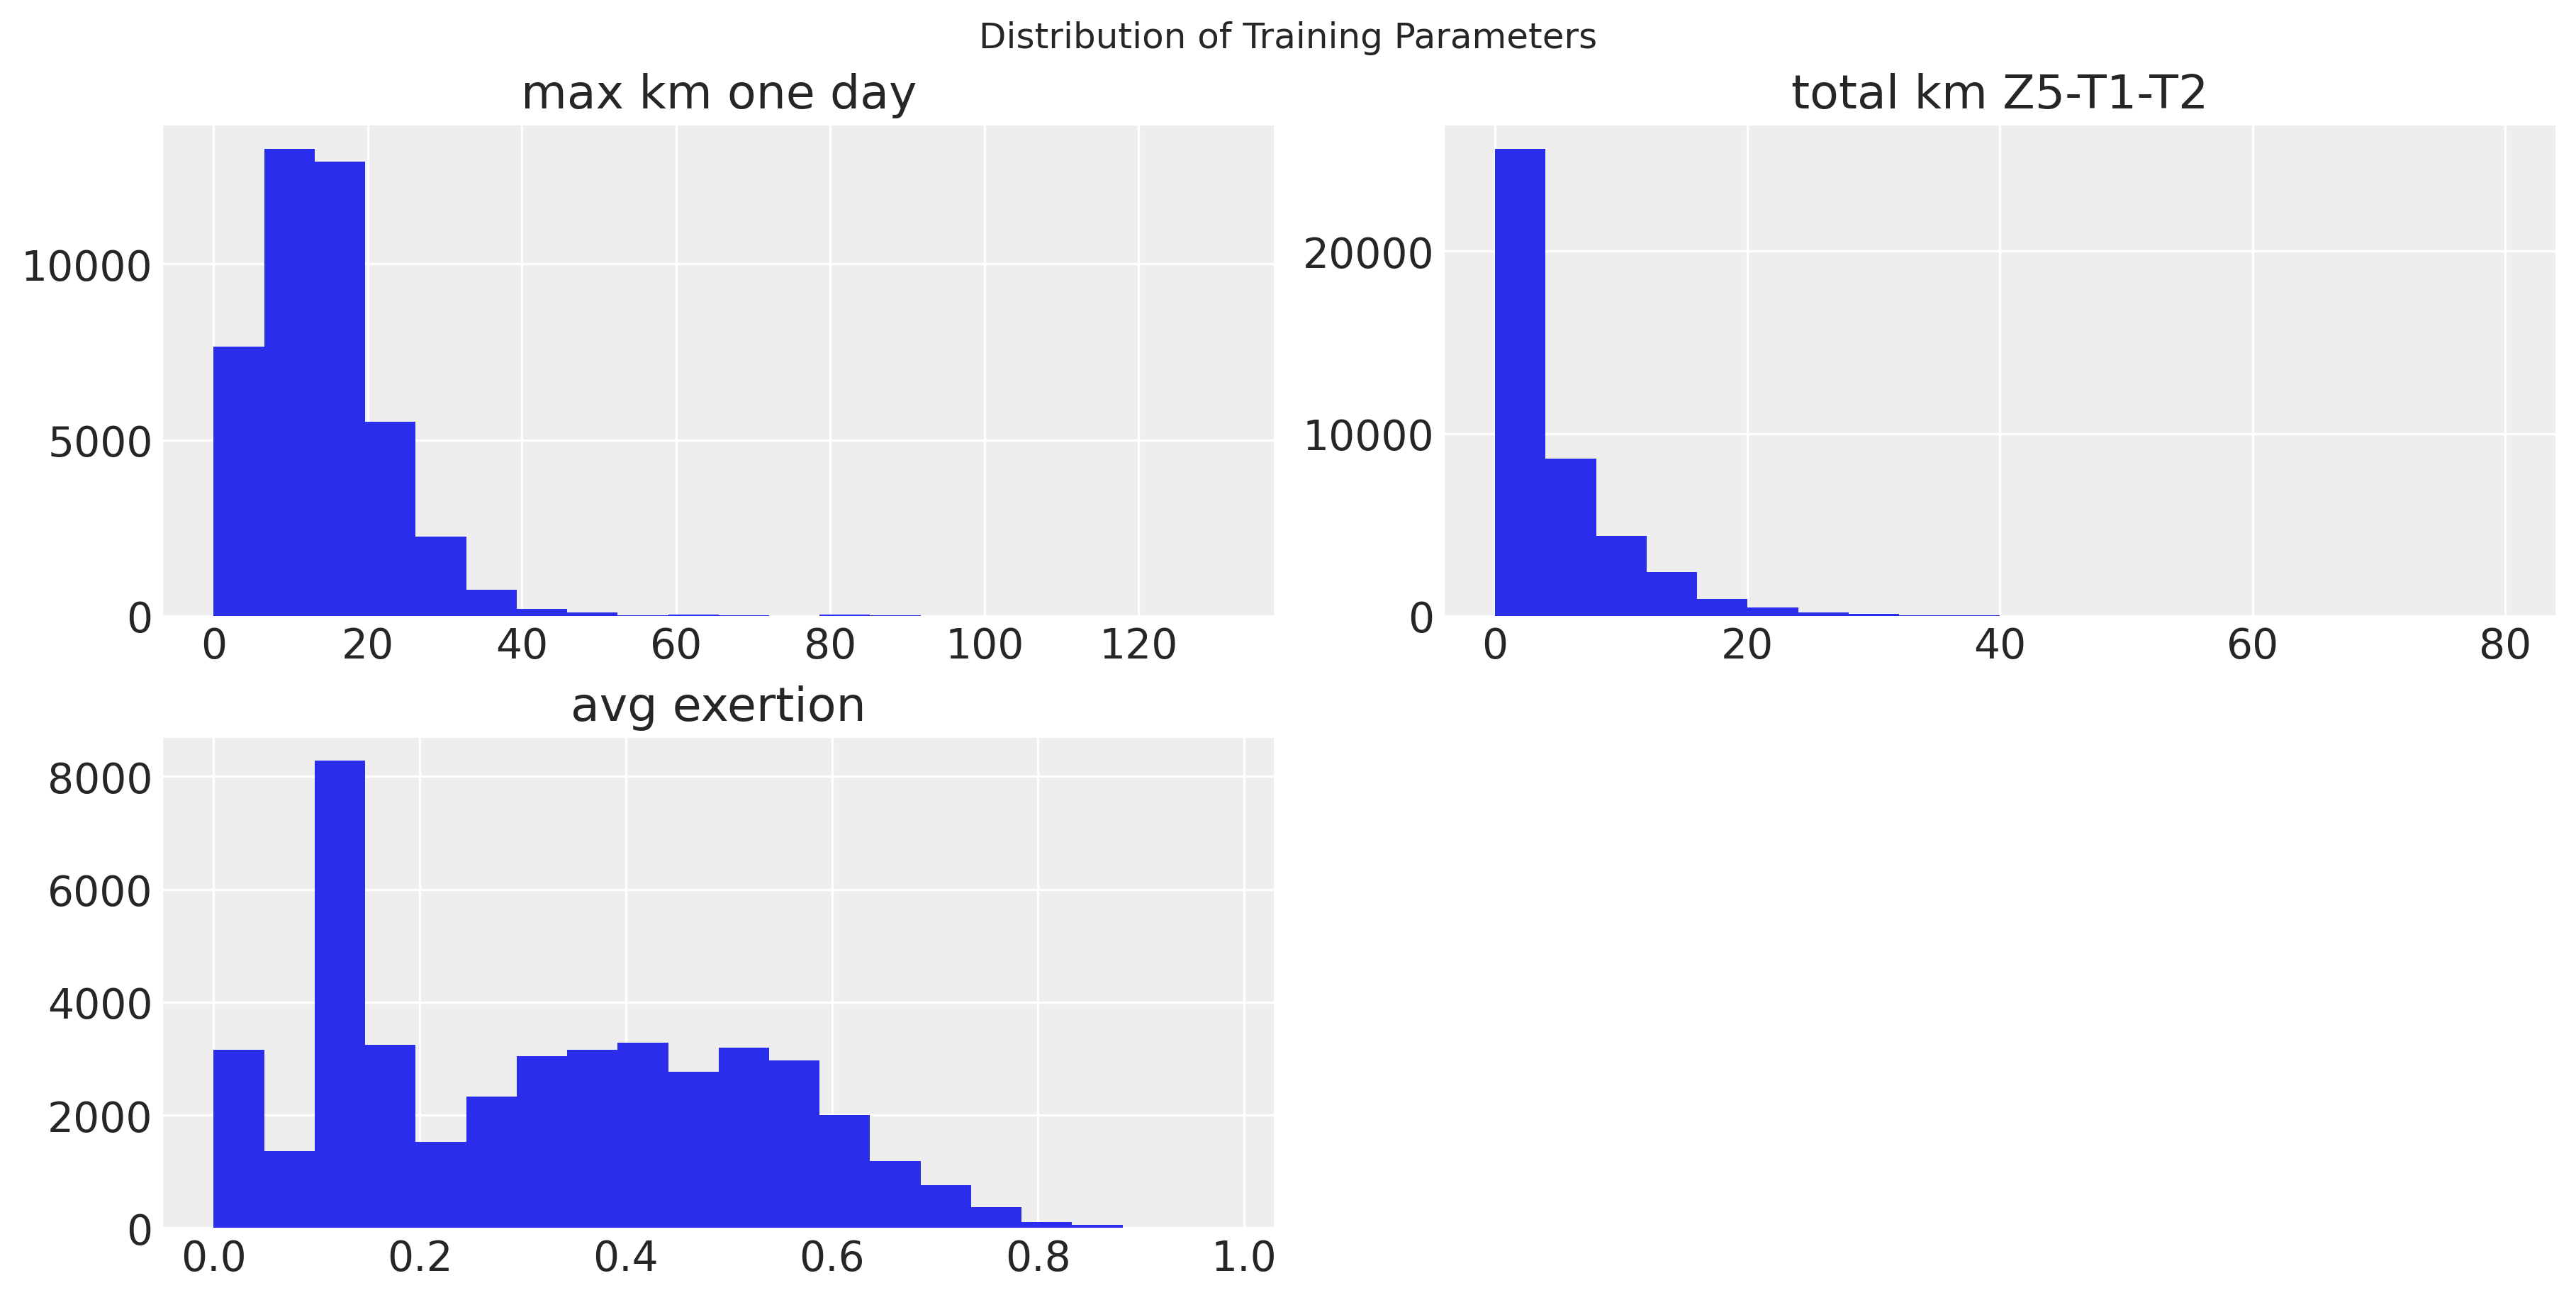

In [8]:
week[['max km one day', 'total km Z5-T1-T2', 'avg exertion']].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribution of Training Parameters')
plt.show()

#### Box Plot

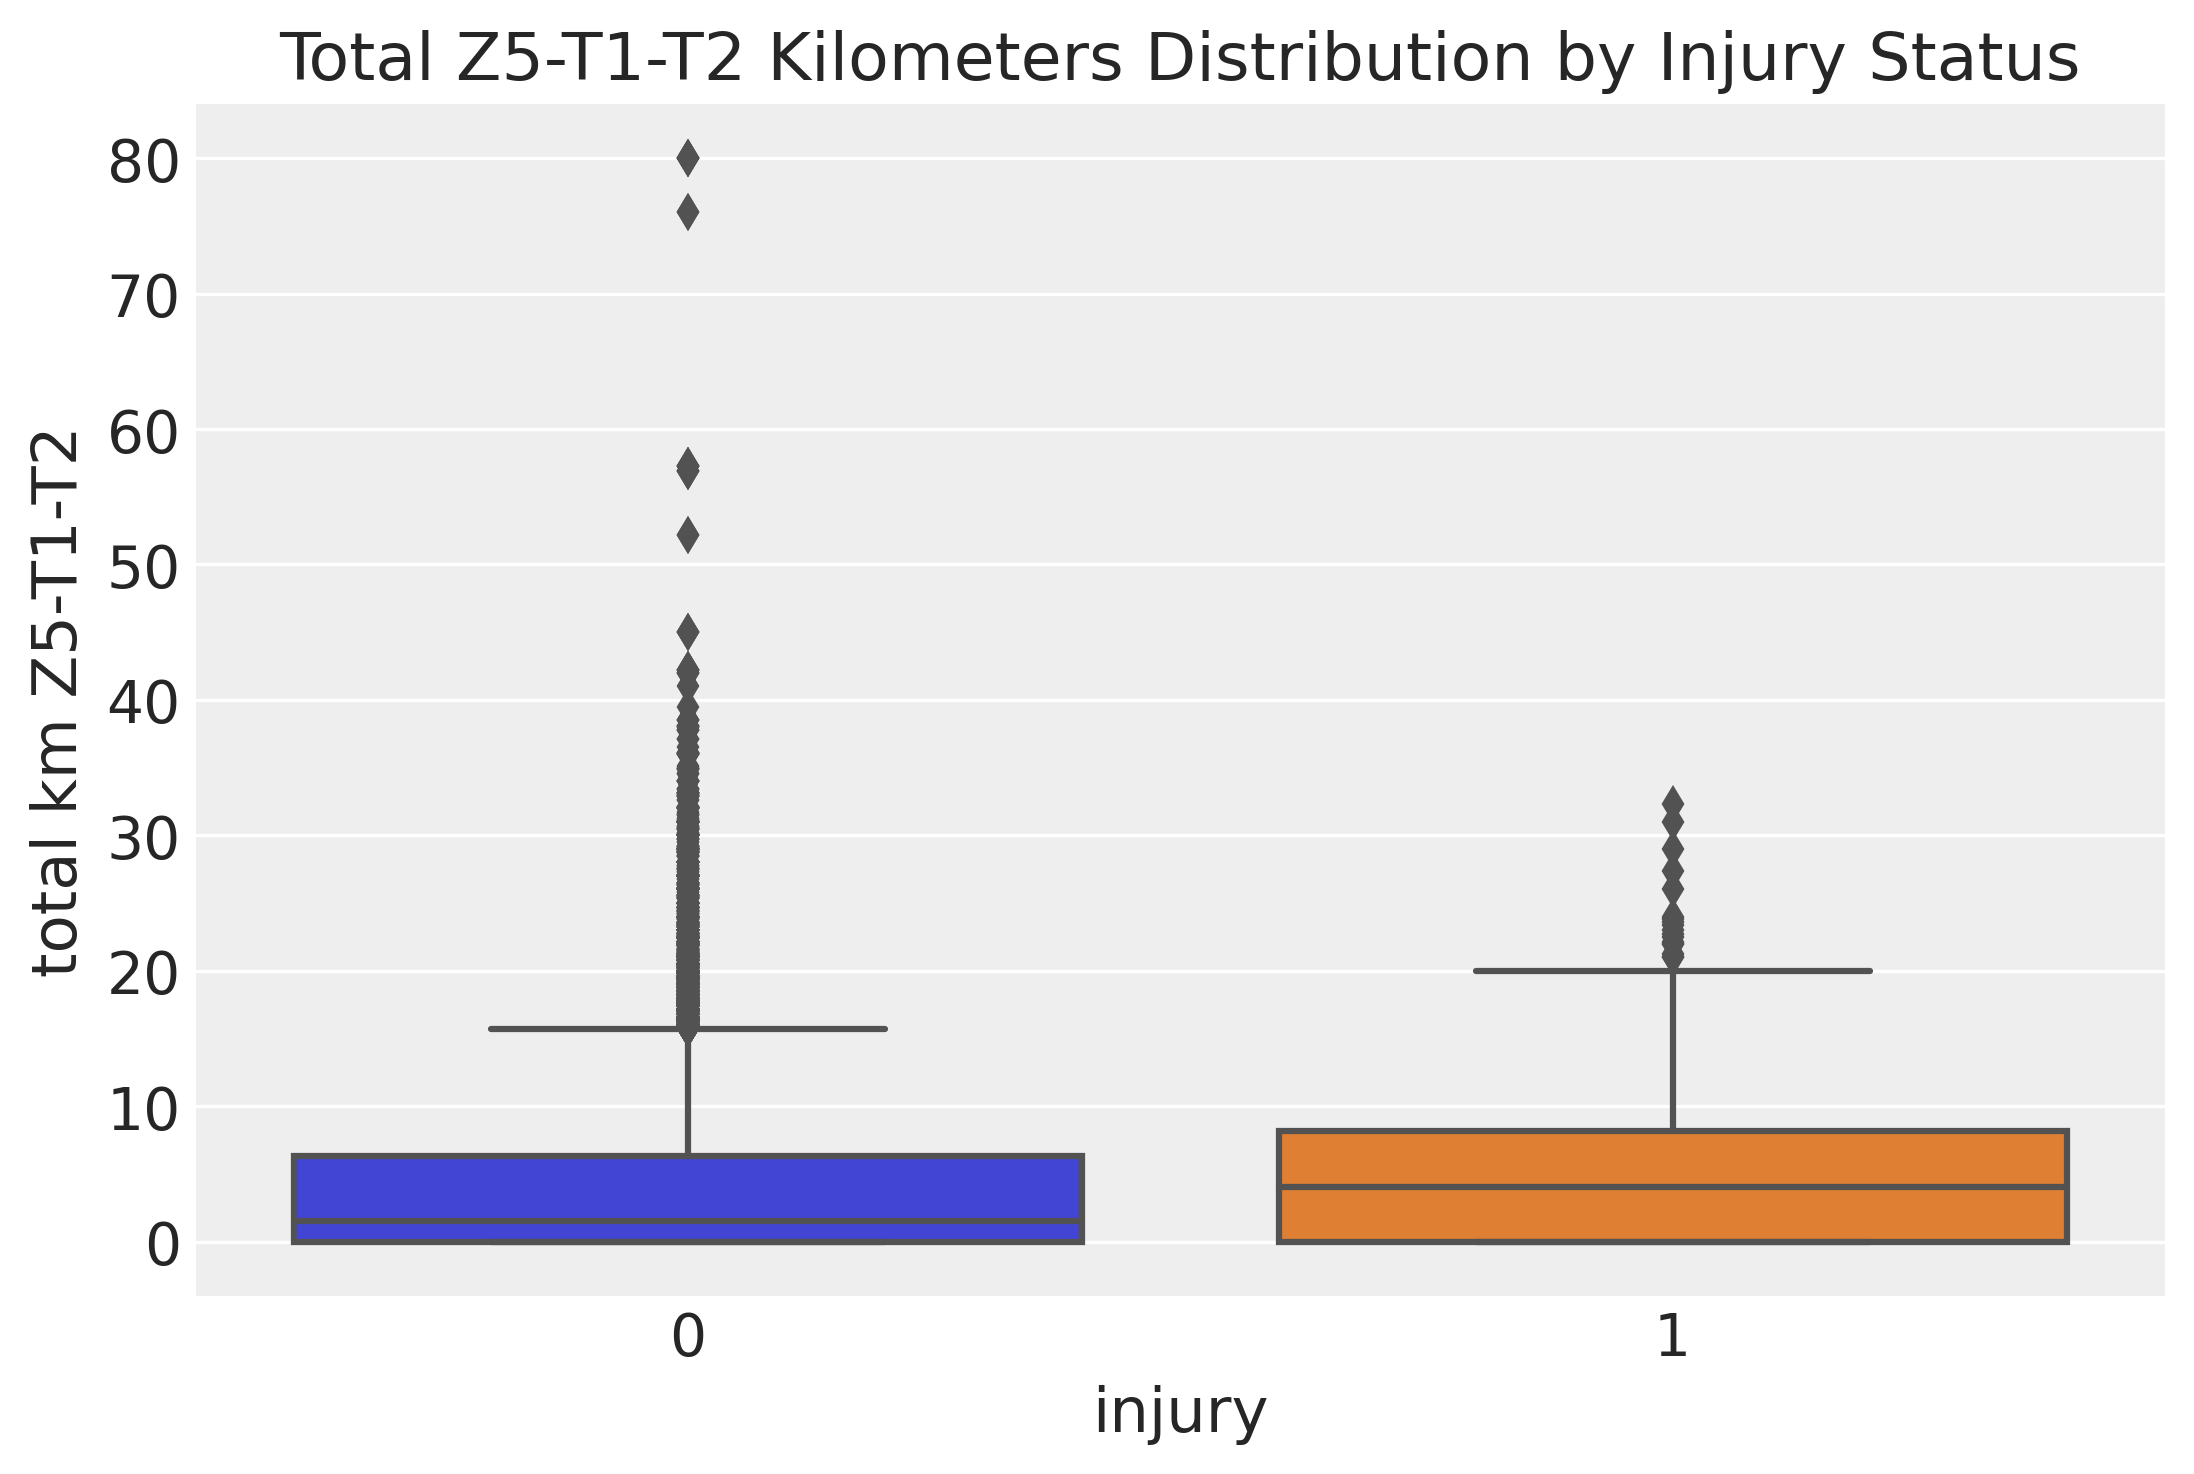

In [9]:
sns.boxplot(x='injury', y='total km Z5-T1-T2', data=week)
plt.title('Total Z5-T1-T2 Kilometers Distribution by Injury Status')
plt.show()

### Data Processing
#### Selecting relevant variables

In [10]:
week = week[["injury",
             "Athlete ID", 
             "max km one day",
             "total km Z5-T1-T2", 
             "avg exertion"
             ]]

#### Renaming columns

In [11]:
week = week.copy()
week.rename(columns = {"max km one day":"max_km_oneday",
                       "total km Z5-T1-T2":"total_kmZ5",
                       "avg exertion":"avg_exertion",
                       "Athlete ID":"id"}, inplace = True)

#### Missing Values

In [12]:
week.isnull().values.any()

False

#### Outliers
##### Calculating the IQR for each variable

In [13]:
Q1 = week[['max_km_oneday', 'total_kmZ5', 'avg_exertion']].quantile(0.25)
Q3 = week[['max_km_oneday', 'total_kmZ5','avg_exertion']].quantile(0.75)
IQR = Q3 - Q1

##### Identify outliers using IQR

In [14]:
outliers_iqr = ((week[[ 'max_km_oneday', 'total_kmZ5', 'avg_exertion']] < (Q1 - 1.5 * IQR)) | (week[['max_km_oneday', 'total_kmZ5', 'avg_exertion']] > (Q3 + 1.5 * IQR)))
outliers_iqr.describe()

max_km_oneday total_kmZ5 avg_exertion
count          42798      42798        42798
unique             2          2            1
top            False      False        False
freq           41543      40964        42798

##### Drop rows containing outliers

In [15]:
week_no_outliers = week.drop(week.index[outliers_iqr.any(axis=1)])

##### Verify that outliers are removed

In [16]:
print("Original DataFrame shape:", week.shape)
print("DataFrame shape after removing outliers:", week_no_outliers.shape)

Original DataFrame shape: (42798, 5)
DataFrame shape after removing outliers: (39912, 5)


#### Resampling
We chose to resample from the original data to account for the small proportion of injury observations compared to non-injured. This way, the response variable is more balanced.

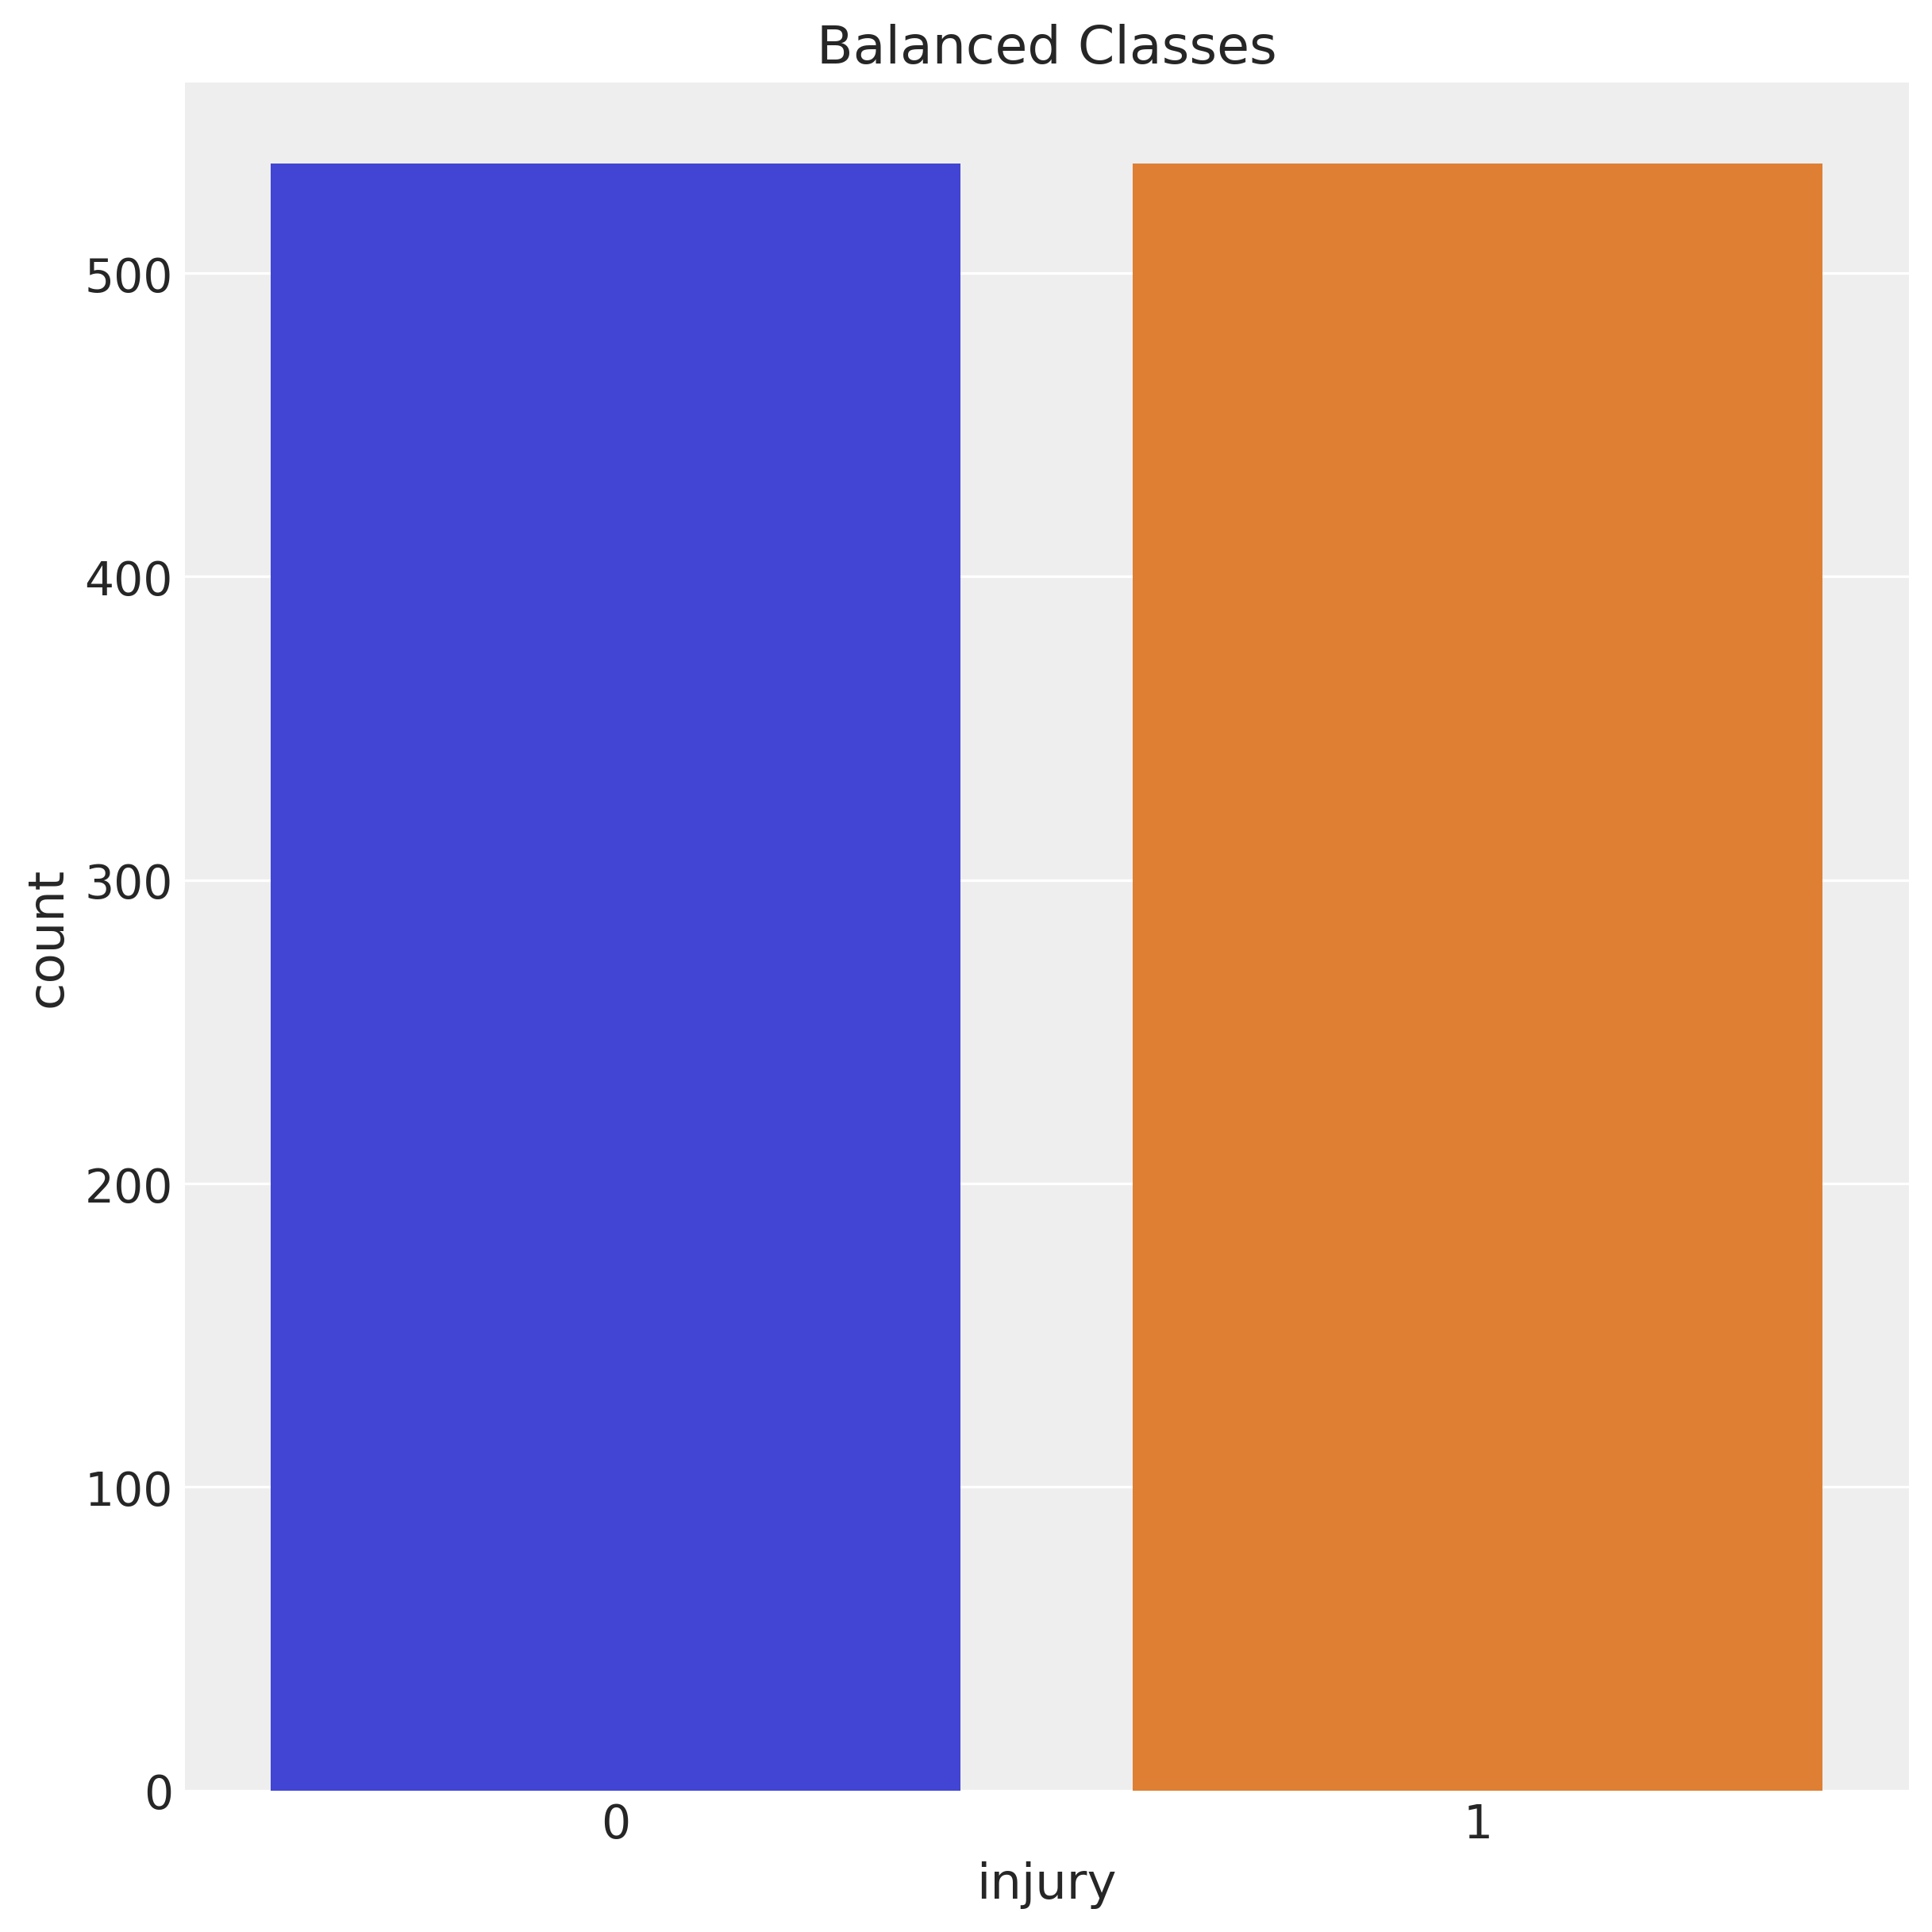

In [17]:
week1 = week_no_outliers.sort_values(by='id')
cts = week1["injury"].value_counts().get(1, 0)
shuff_week1 = week1.sample(frac=1, random_state=4)
inj_week1 = shuff_week1.loc[shuff_week1['injury'] == 1]
non_inj_week1 = shuff_week1.loc[shuff_week1['injury'] == 0].sample(n=cts)
norm_week = pd.concat([inj_week1, non_inj_week1])

import warnings
# Ignore FutureWarning related to is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(8, 8))
sns.countplot(x='injury', data=norm_week)
plt.title("Balanced Classes")
plt.show()

#### Correlation Heatmap with the cleaned data

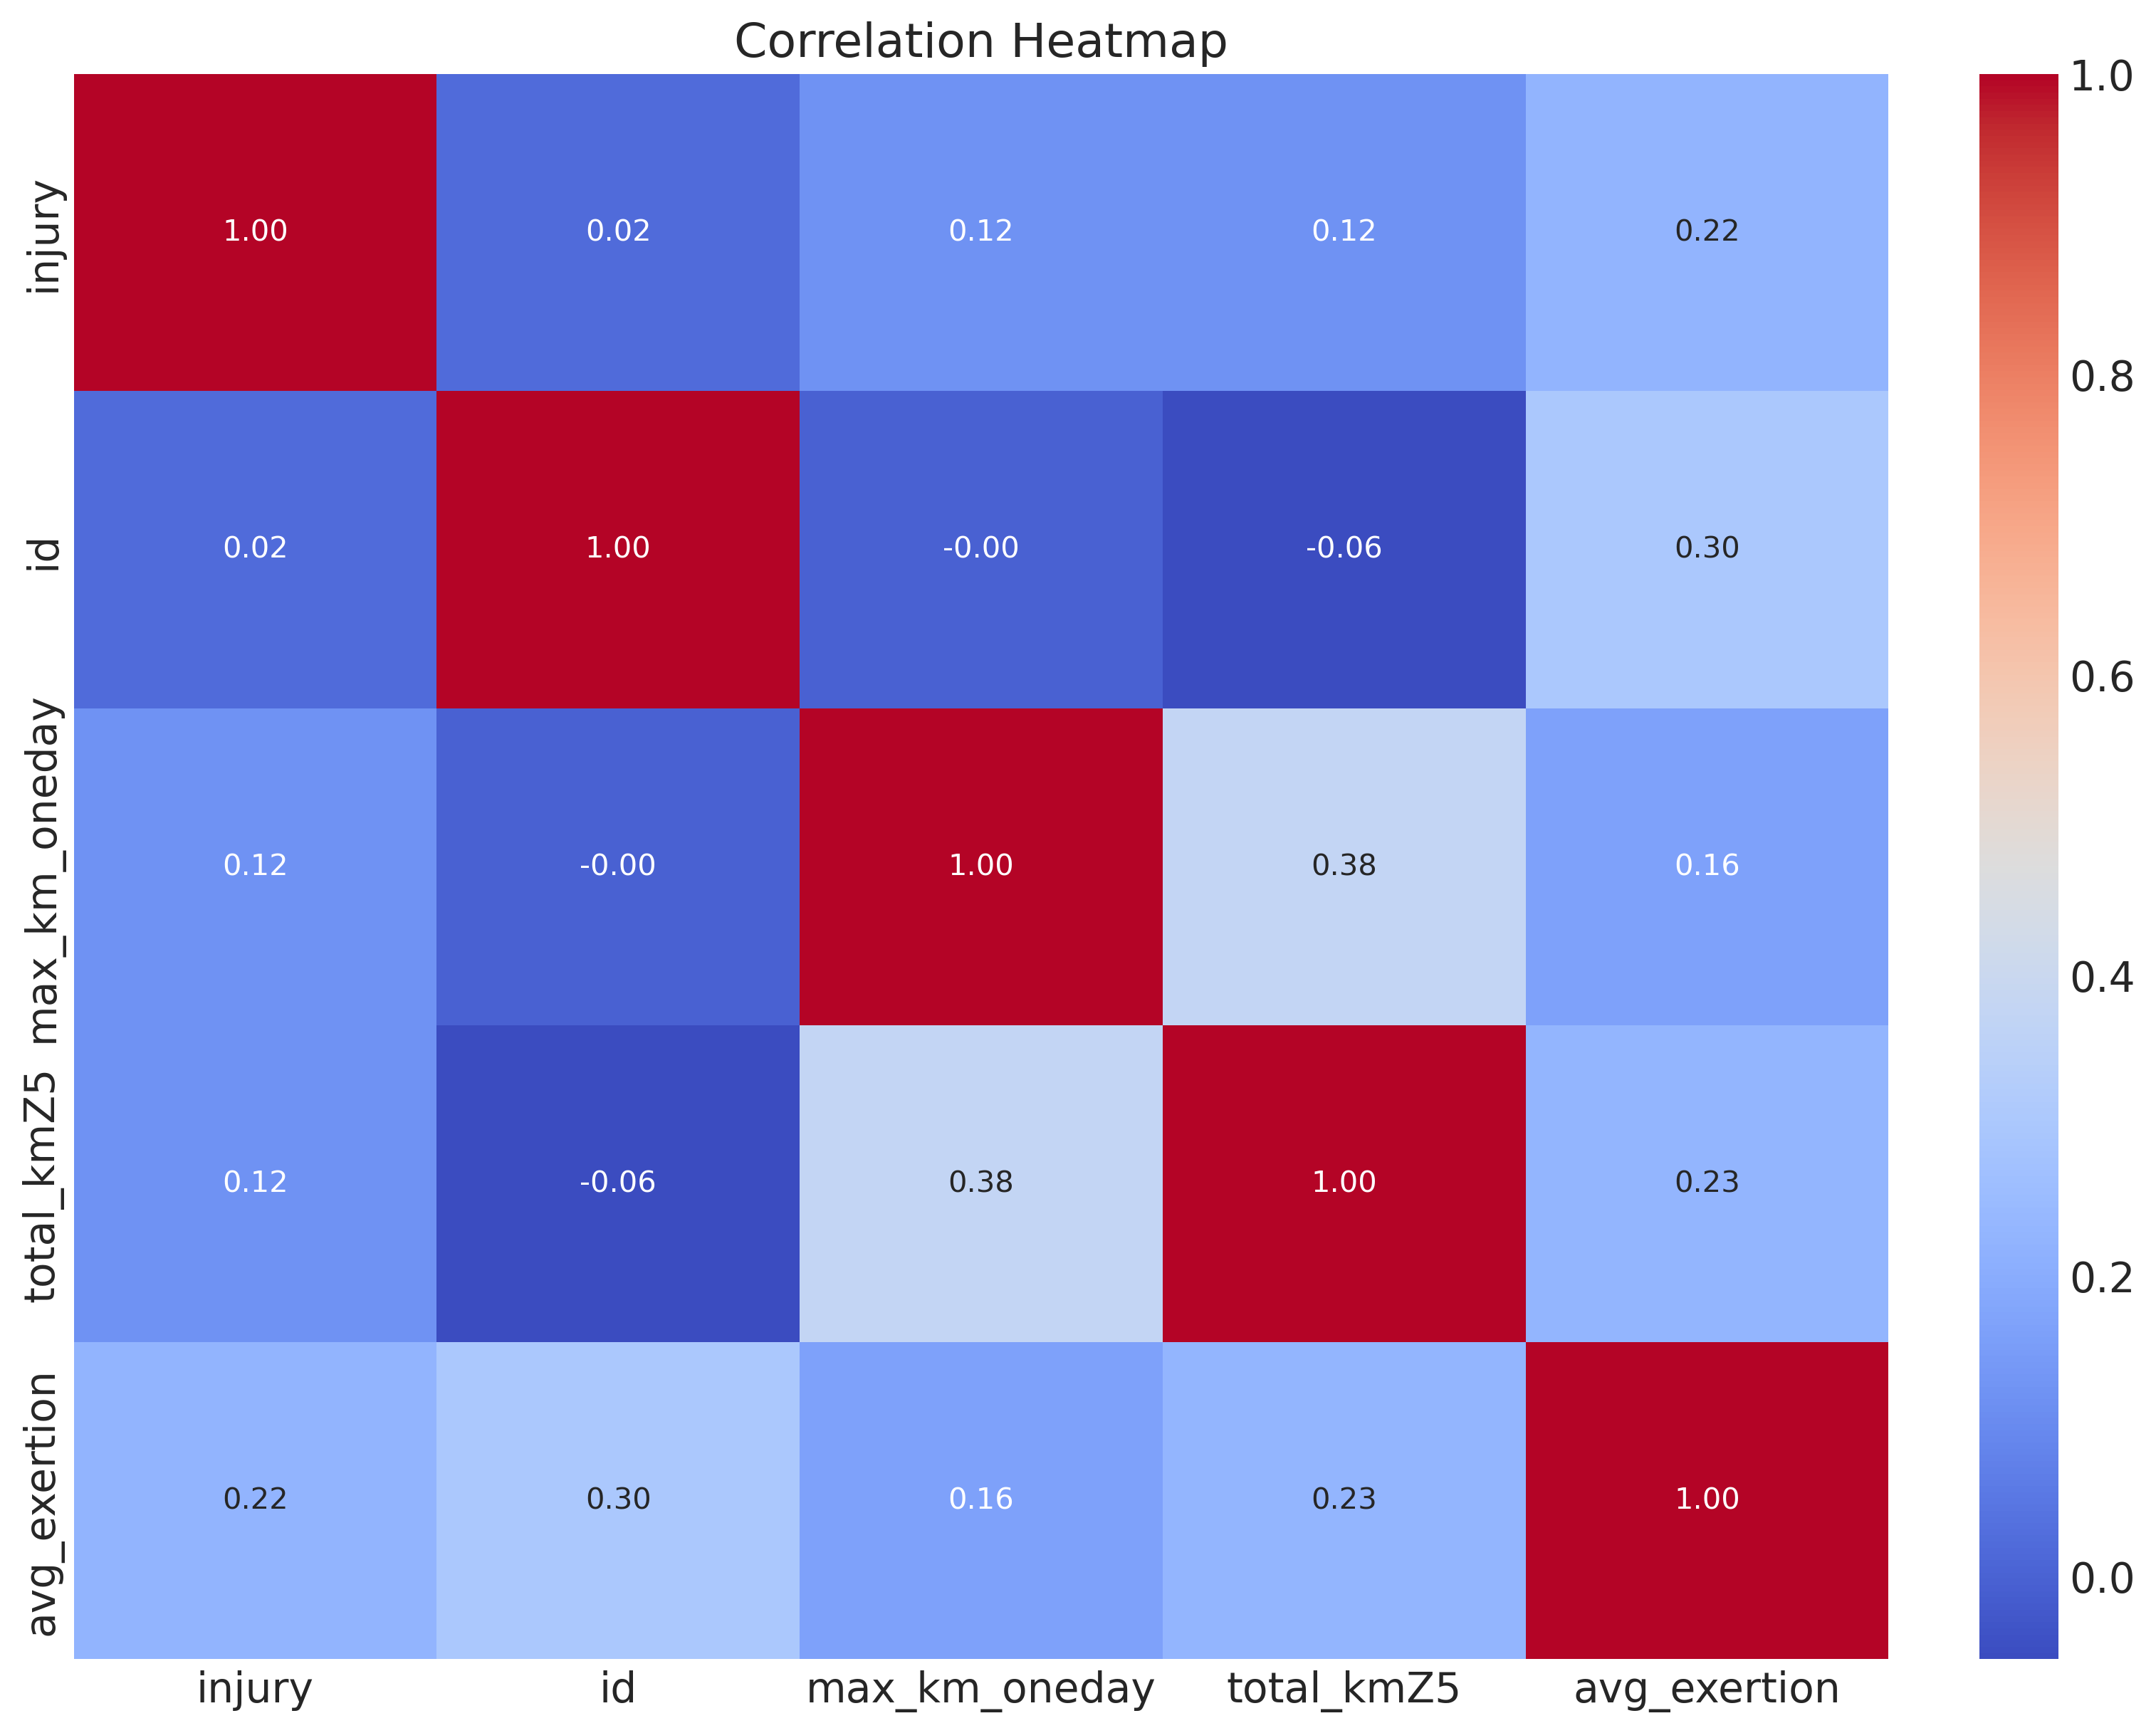

In [18]:
# Calculate correlation matrix
correlation_matrix = norm_week.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Categorizing the response variable

In [20]:
norm_week['injury'] = norm_week['injury'].astype('category')
norm_week['injury']

42714    1
42535    1
42726    1
42227    1
42718    1
        ..
13551    0
12073    0
1551     0
34939    0
35194    0
Name: injury, Length: 1072, dtype: category
Categories (2, int64): [0, 1]

#### Scaling predictors

In [21]:
#Predictors
predictors = ["max_km_oneday", "total_kmZ5", "avg_exertion"]
n = norm_week.shape[0]

#Subsetting Data
x_num = norm_week[predictors]
y = norm_week['injury']

# Standardize numeric columns, to mean 0 variance 1
mean = x_num.mean()
std = x_num.std()
x_num = np.array((x_num - mean) / std)

X = x_num
k = X.shape[1]

### Model Creation

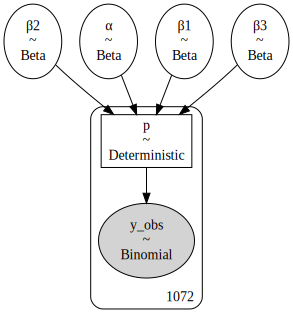

In [27]:
with pm.Model() as glm:
    α = pm.Beta('α', alpha = 1, beta = 1) #intercept
    β1 = pm.Beta('β1', alpha = 1, beta = 1) #max kilometers in one day
    β2 = pm.Beta('β2', alpha = 1, beta = 1) #total kilometers ran with anaerobic heart rate
    β3 = pm.Beta('β3', alpha = 1, beta = 1) #average exertion
    μ =  α + β1 * X[:,0] + β2 * X[:,1] + β3 * X[:,2]
    p = pm.Deterministic("p", pm.invlogit(μ))
    y_obs = pm.Binomial('y_obs', n = 1, p = p, observed = y) 
    
pm.model_to_graphviz(glm)

#### HMC Sampling

In [28]:
#HMC Trace
with glm:
    trace = pm.sample(1000, tune = 2000, random_seed = random_seed, cores = 4, return_inferencedata = False)
    glm_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


#### Prior Predictive Check

In [29]:
with glm:
    prior_p = pm.sample_prior_predictive(random_seed=random_seed)

Sampling: [y_obs, α, β1, β2, β3]


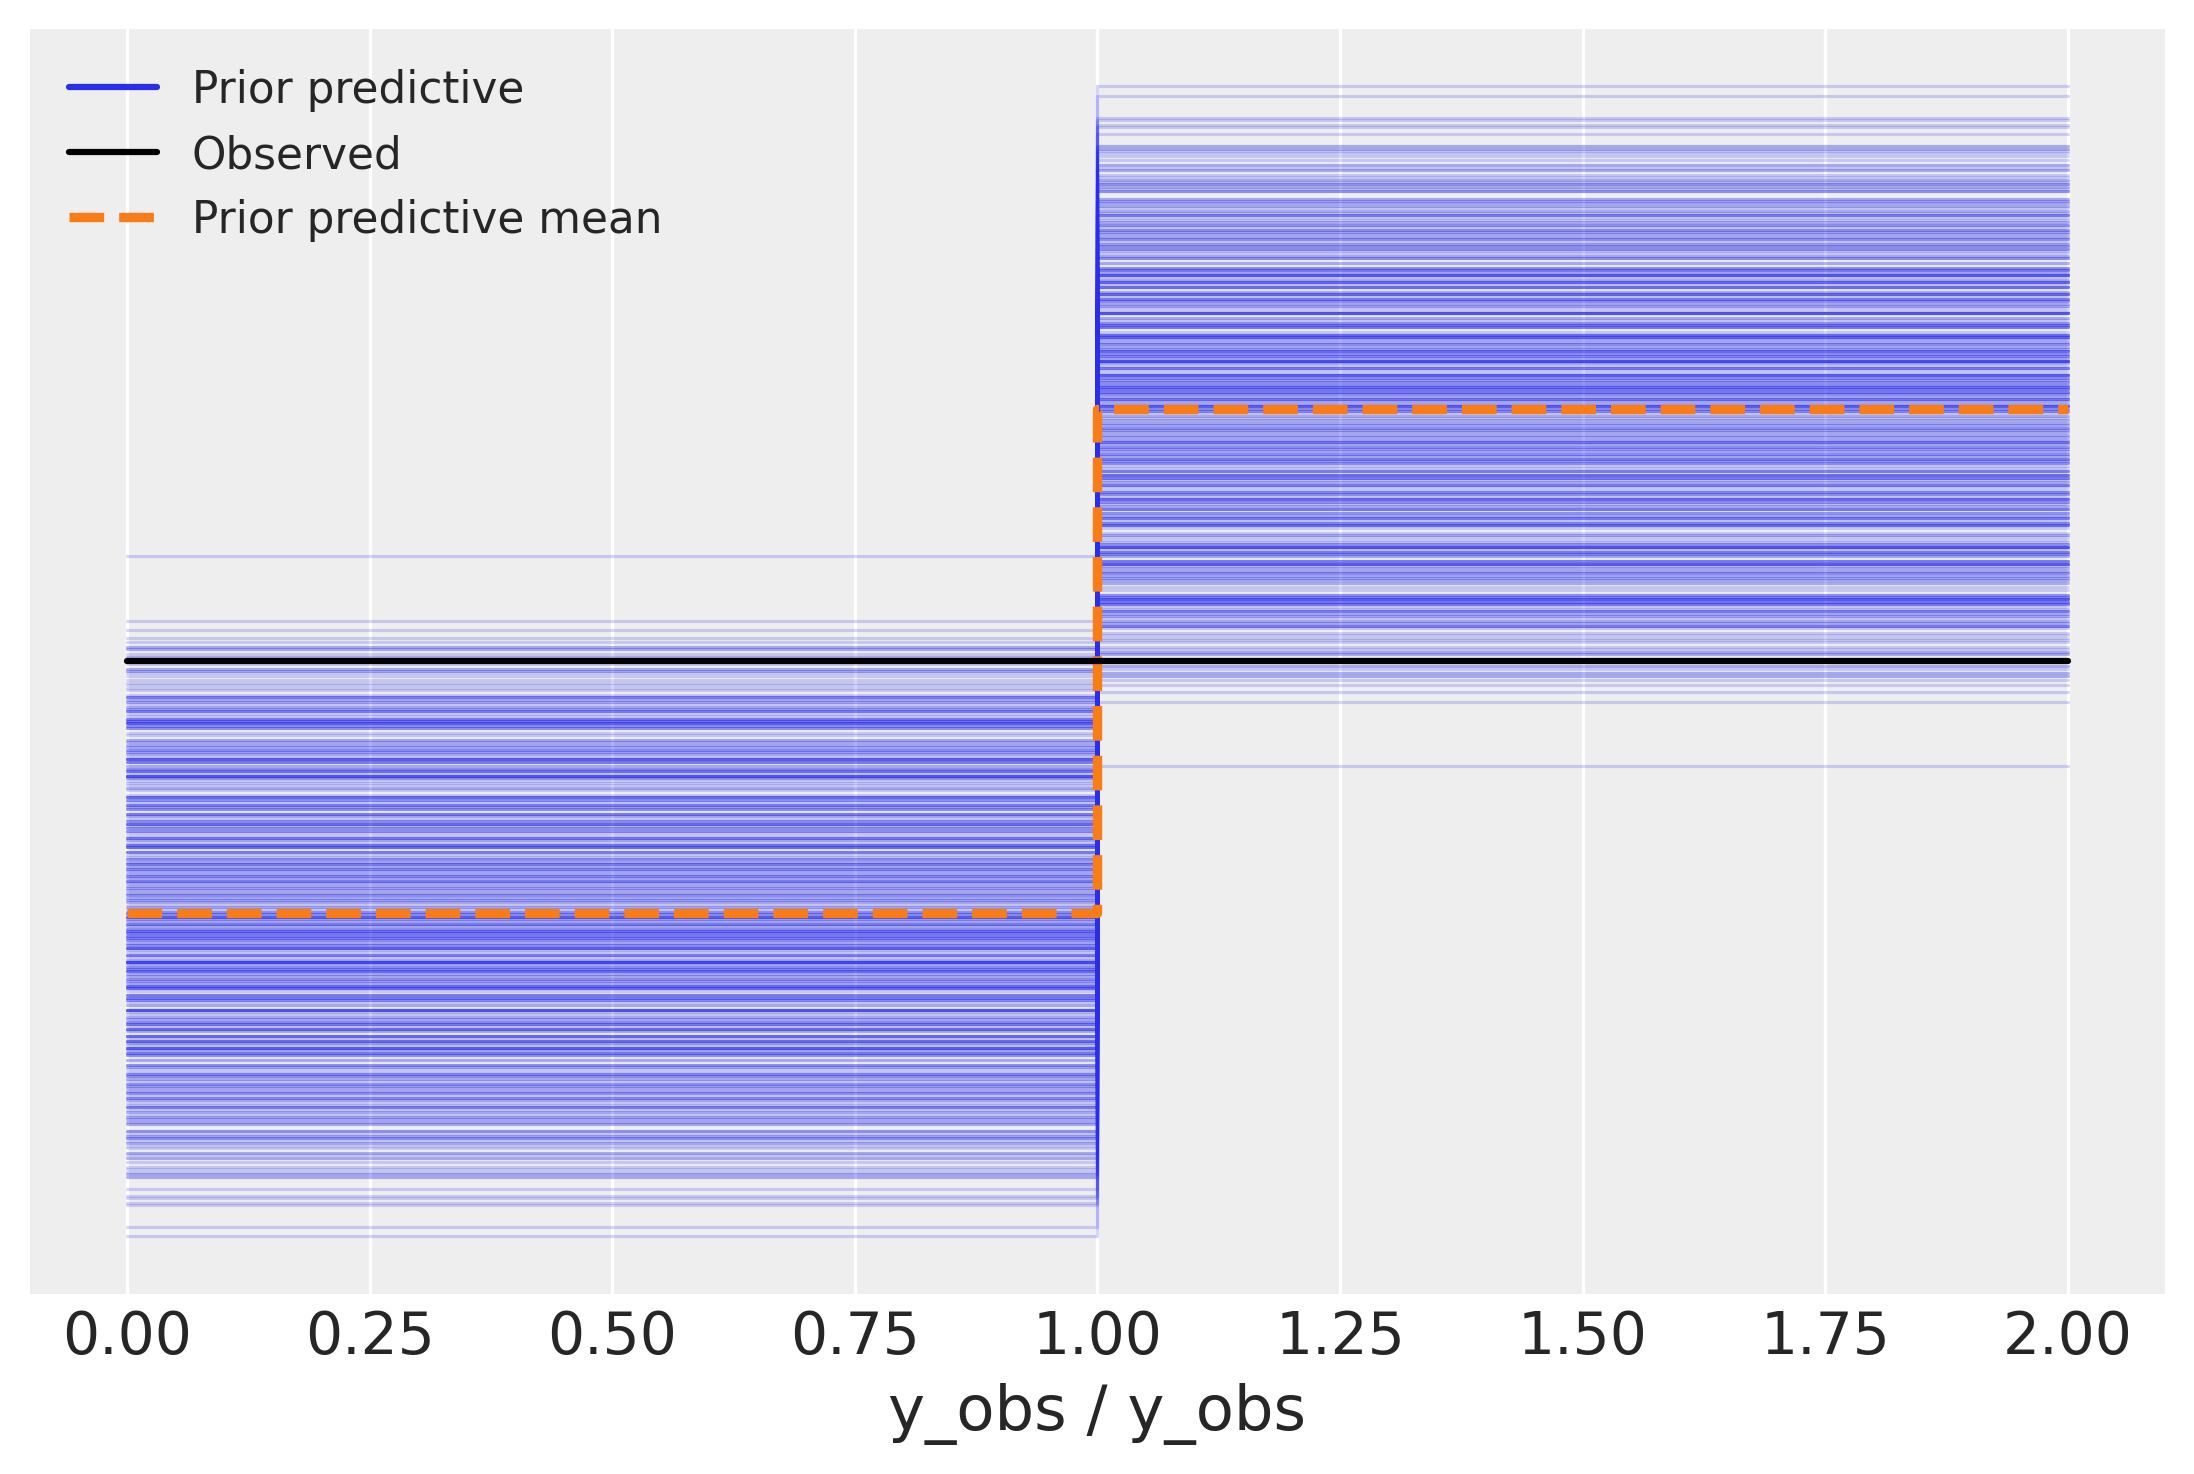

In [30]:
az.plot_ppc(prior_p, group="prior");

#### ADVI Approximation

In [31]:
with glm:
    advi_fit = pm.fit(10000, method='advi', random_seed = random_seed)

Finished [100%]: Average Loss = 719.27


In [32]:
advi_samples = 1000
advi_trace = advi_fit.sample(advi_samples)

### HMC Evaluation
#### Trace Plot

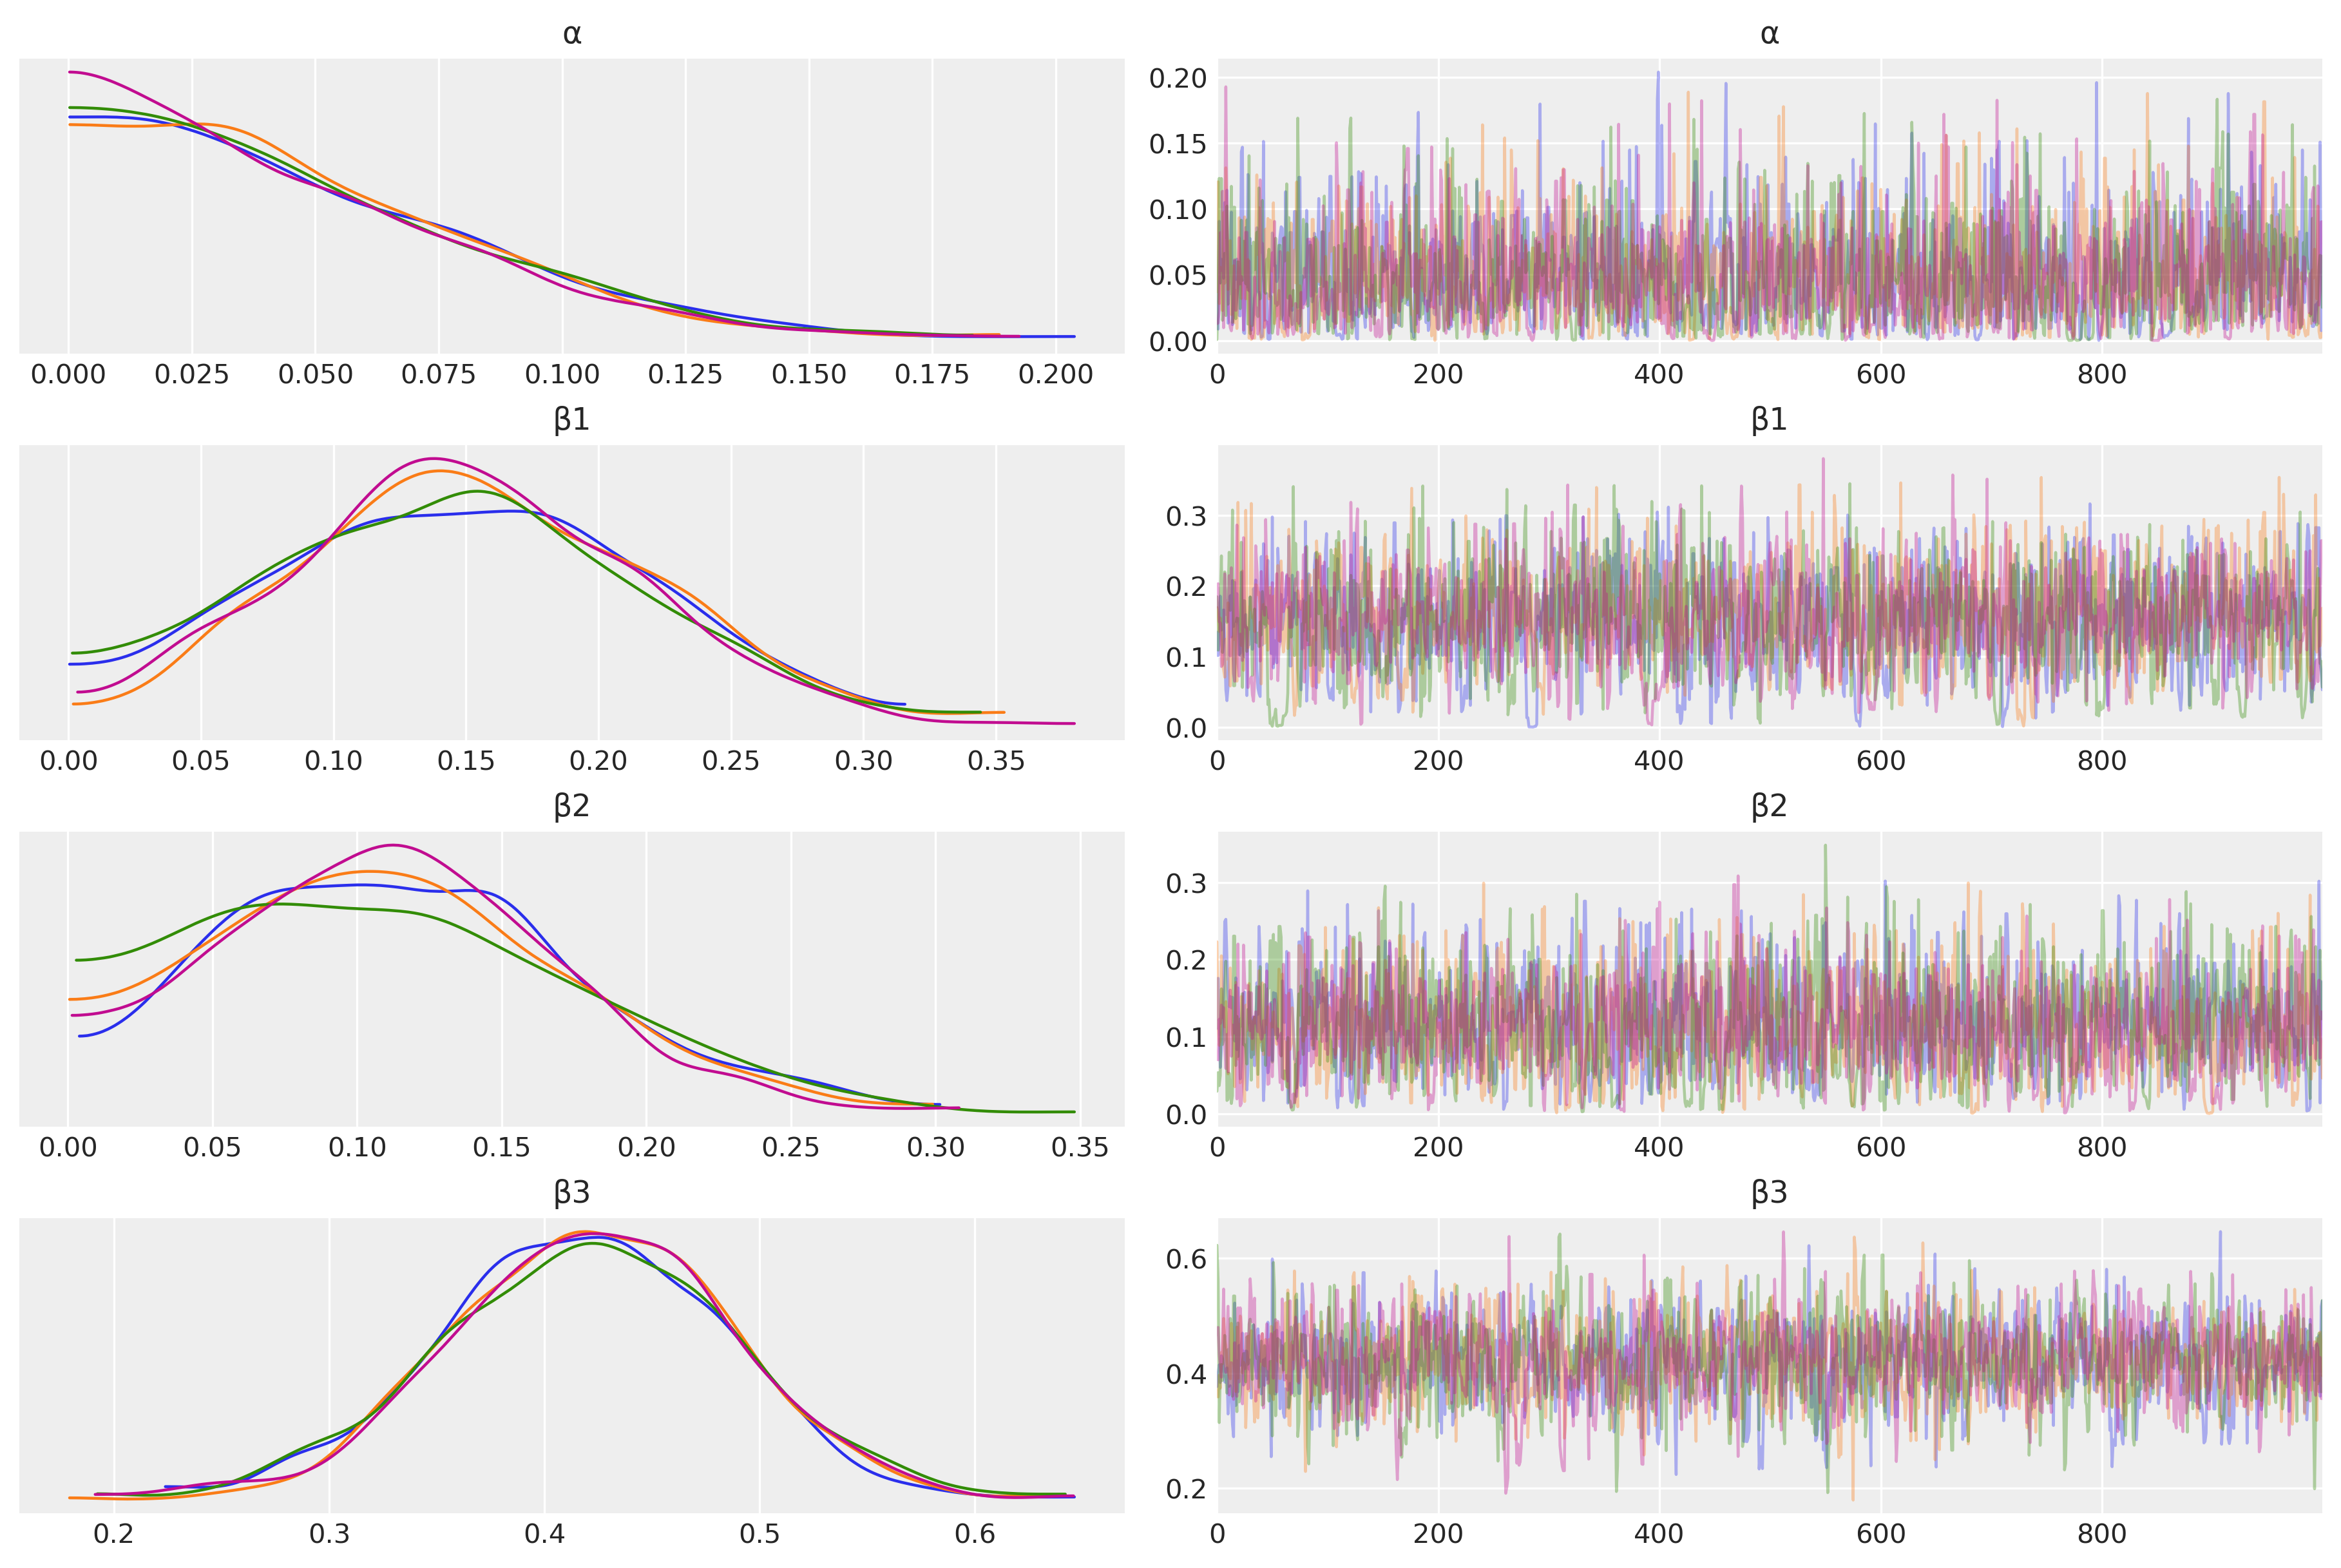

In [33]:
az.plot_trace(glm_trace, compact = False, var_names = ['α','β1','β2', 'β3']);

#### WAIC and LOO

In [34]:
#WAIC
az.waic(glm_trace)

Computed from 4000 posterior samples and 1072 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -713.78     7.90
p_waic        3.07        -

In [35]:
az.loo(glm_trace)

Computed from 4000 posterior samples and 1072 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -713.79     7.90
p_loo        3.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1072  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Posterior Predictive Check

In [36]:
with glm:
    ppc = pm.sample_posterior_predictive(trace = glm_trace, random_seed = random_seed)

Sampling: [y_obs]


<Axes: title={'center': 'y_obs / y_obs'}>

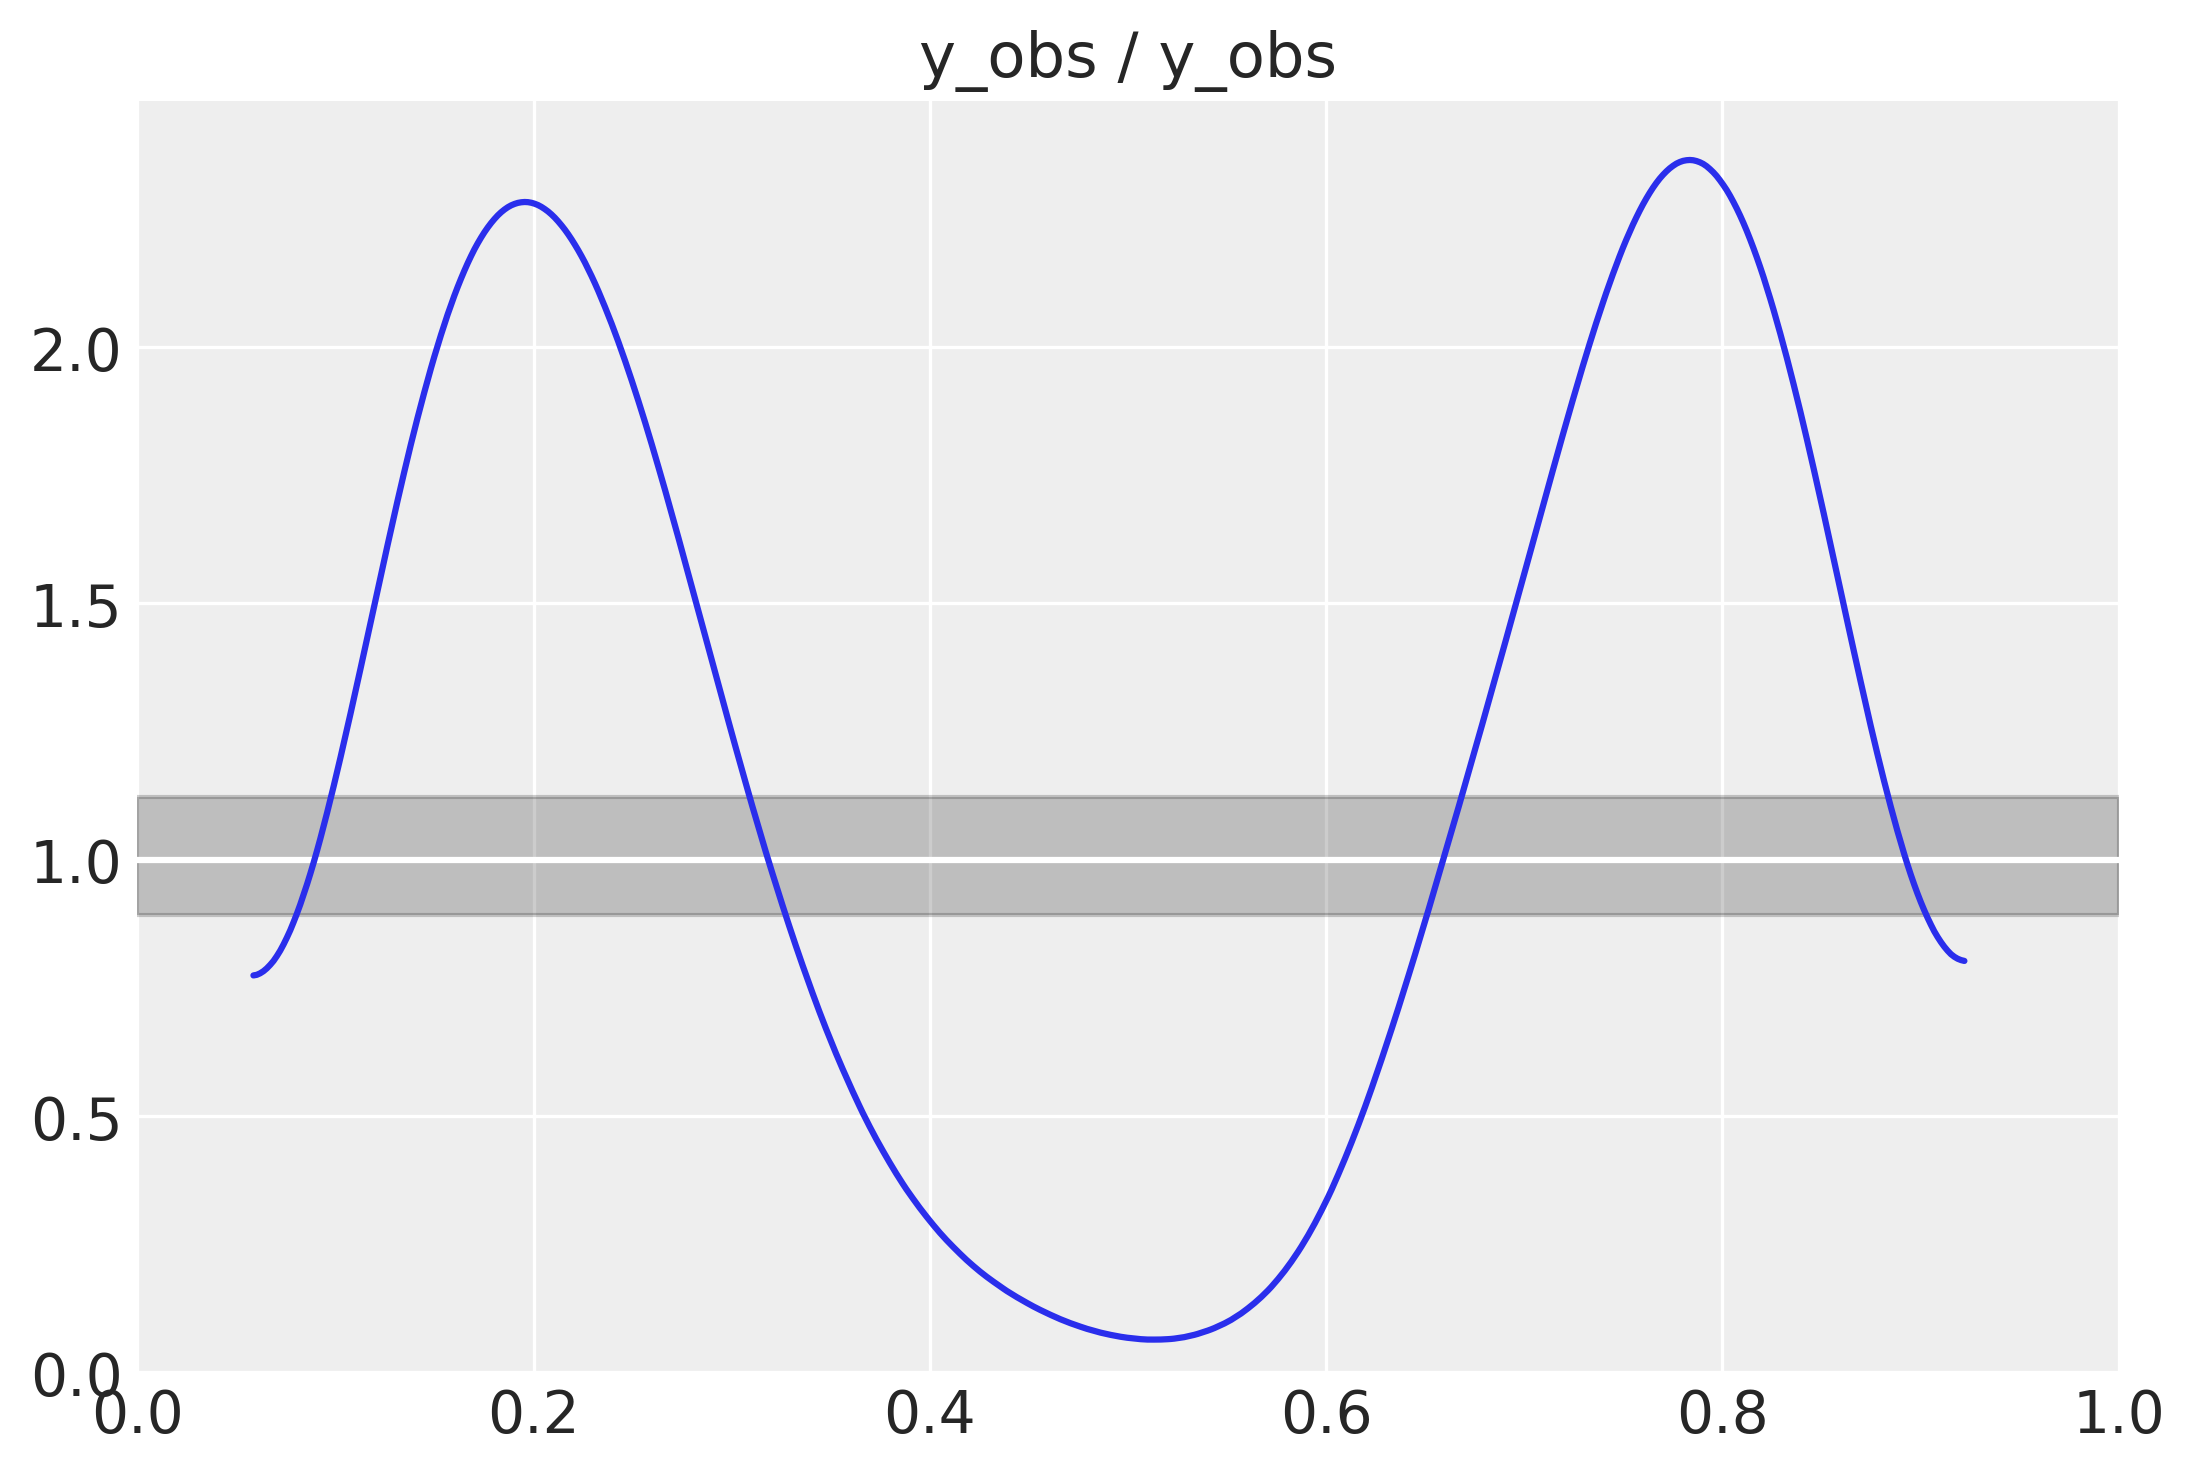

In [37]:
az.plot_bpv(ppc)

<Axes: xlabel='y_obs / y_obs'>

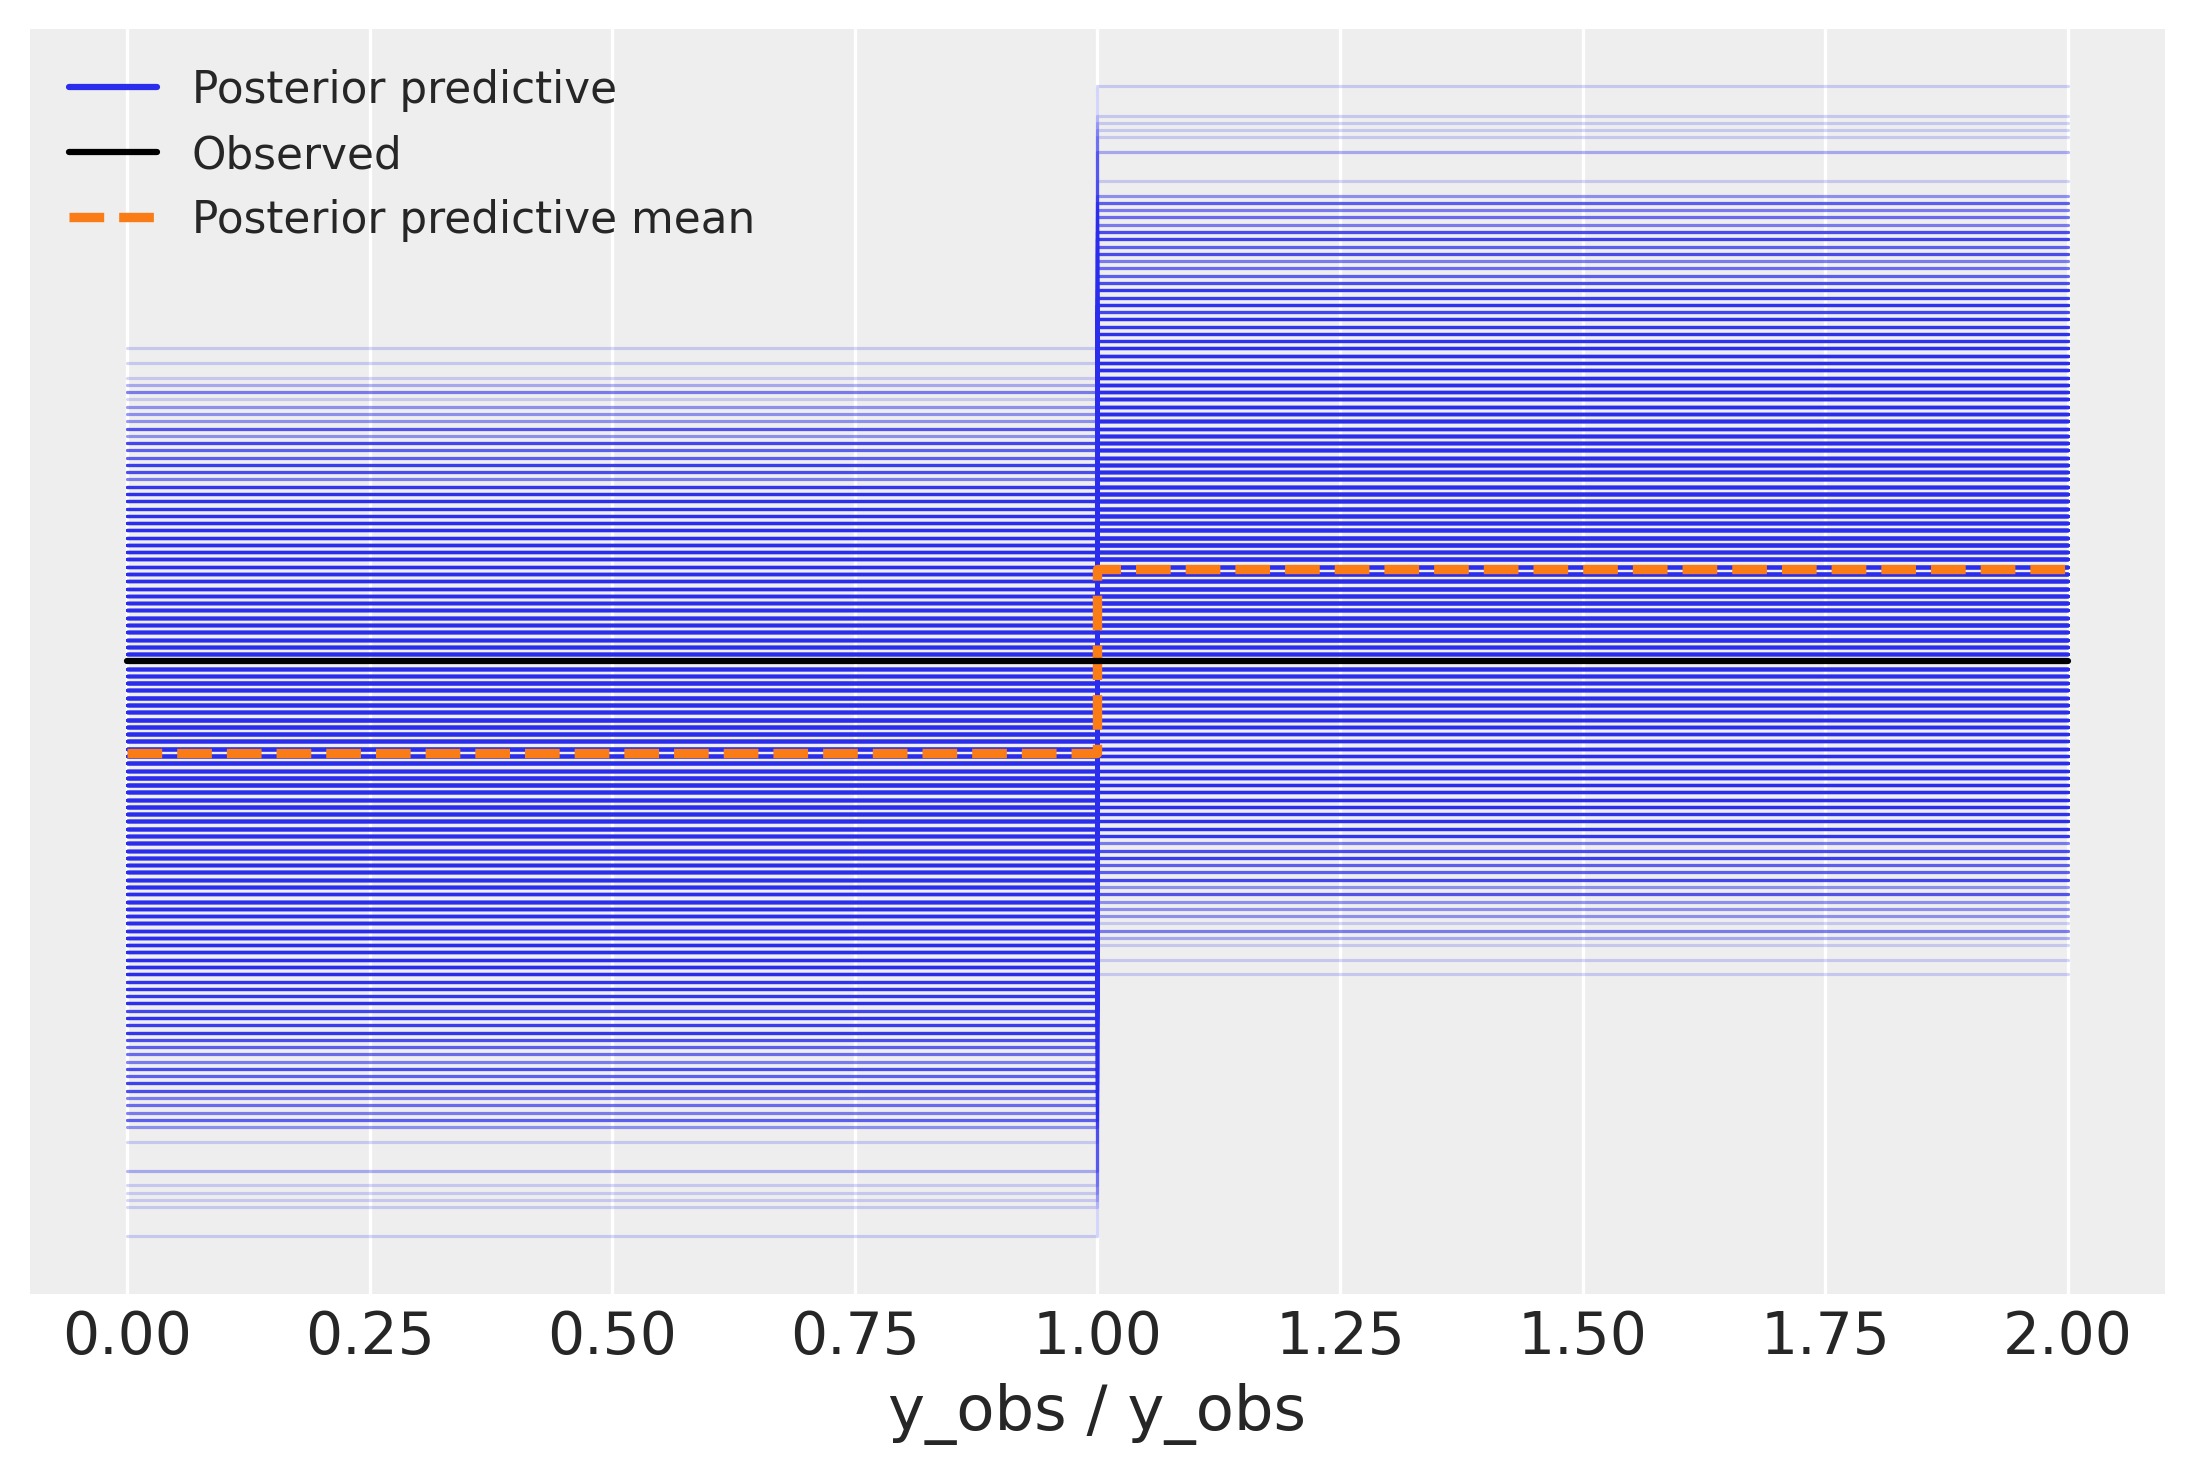

In [38]:
az.plot_ppc(ppc)

#### Forest Plot

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

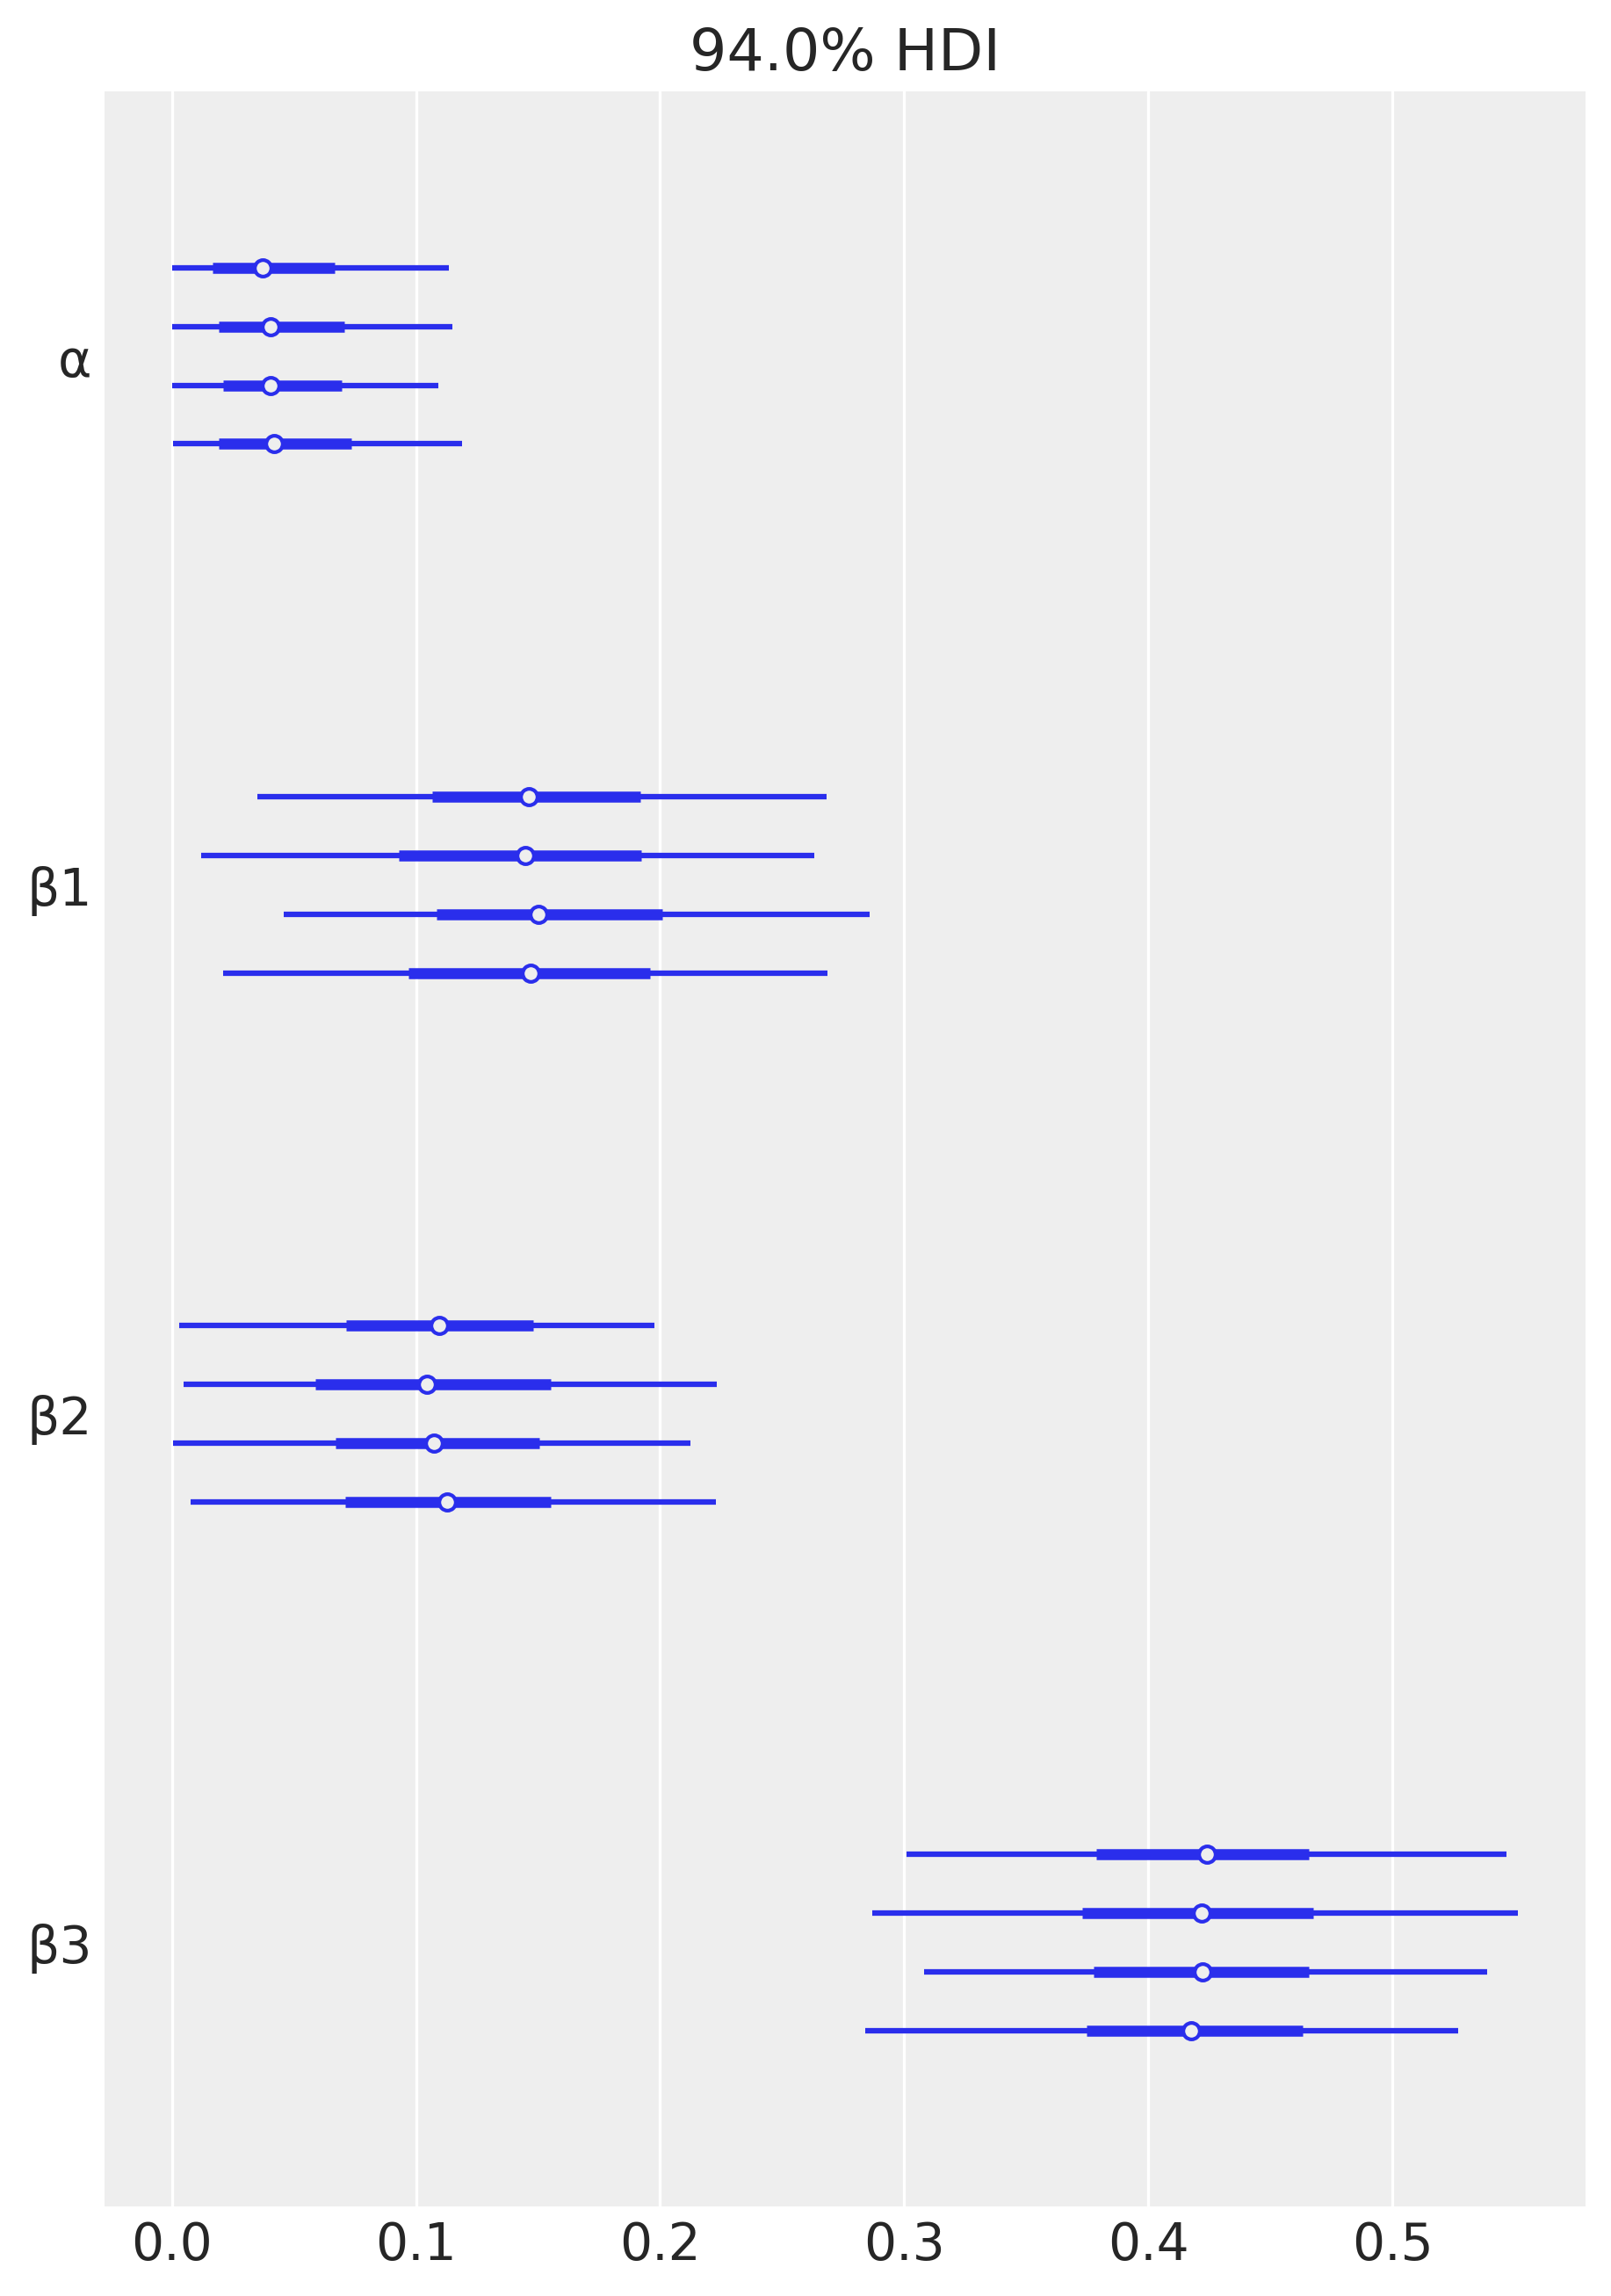

In [39]:
az.plot_forest(glm_trace, var_names = ['α',"β1",'β2', 'β3'])

#### Posterior Parameters

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β1'}>,
       <Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β3'}>],
      dtype=object)

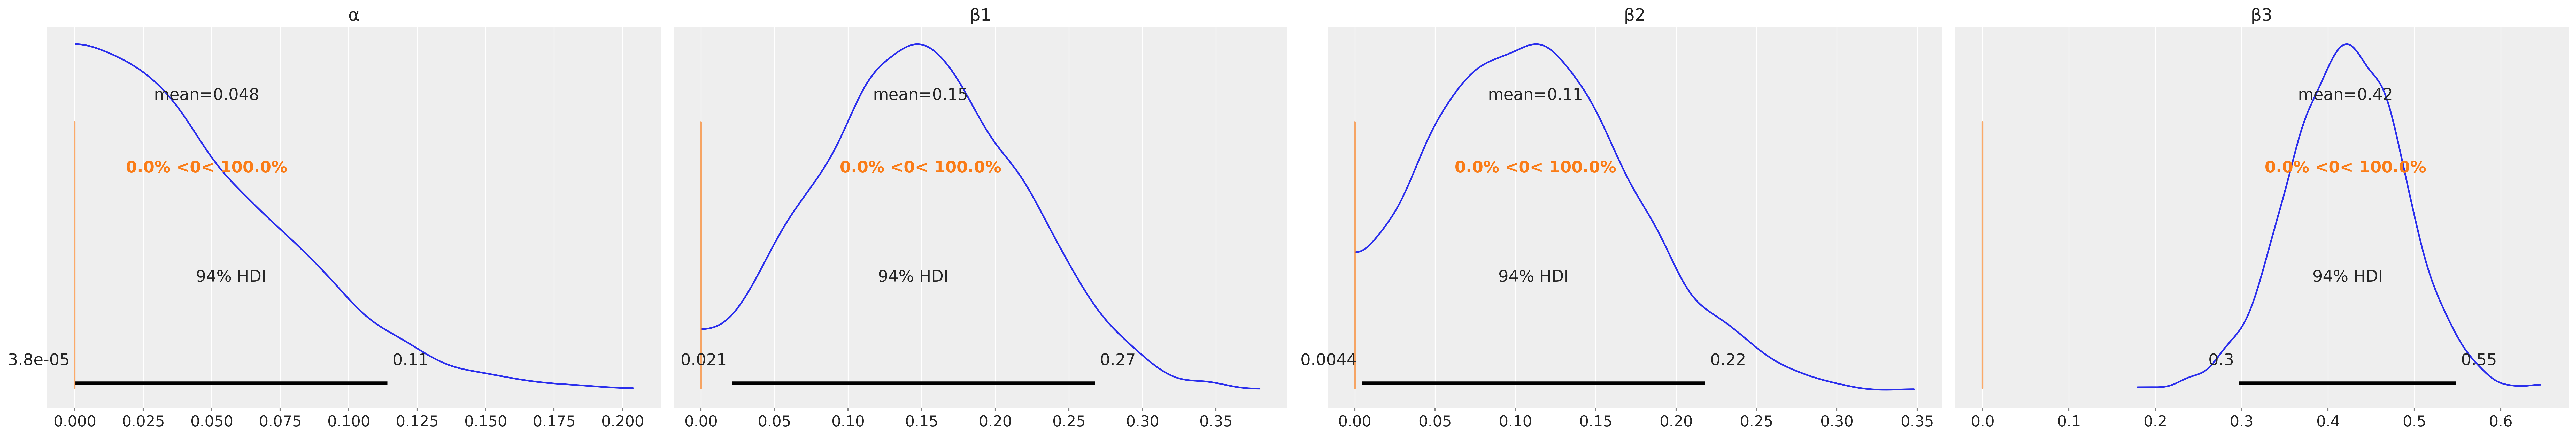

In [40]:
az.plot_posterior(glm_trace, var_names=['α',"β1",'β2', 'β3'], ref_val = 0)

#### 95% HDI plot of P(Injury) by Average Exertion

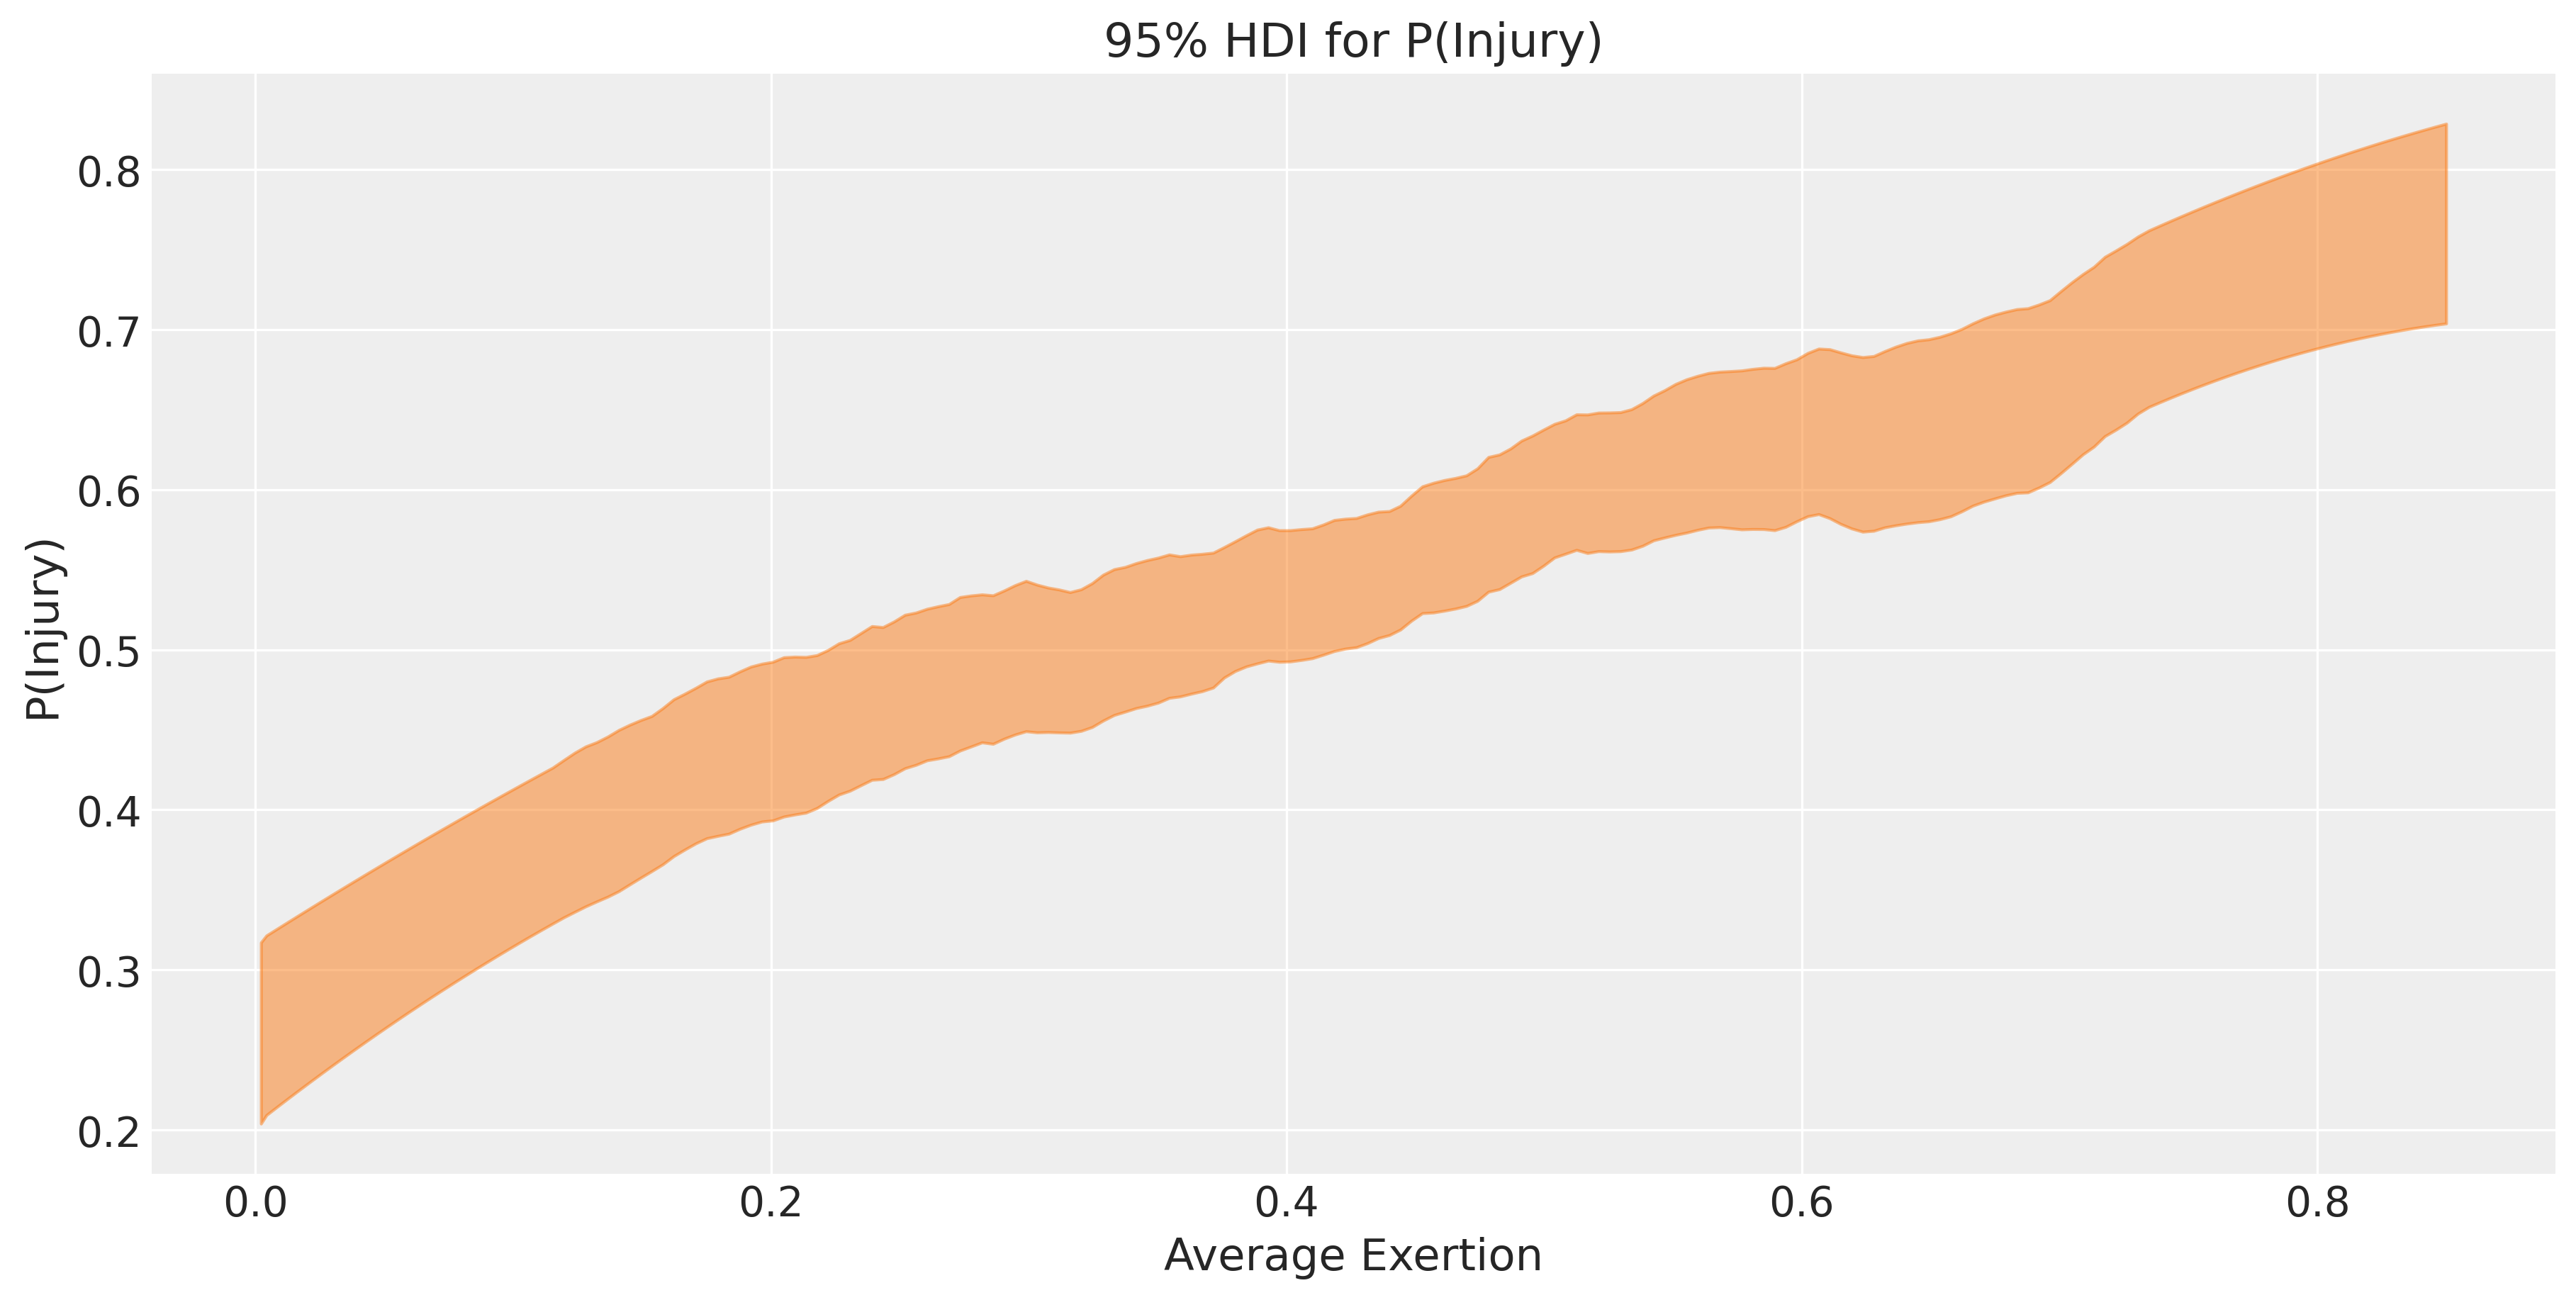

In [41]:
_, ax = plt.subplots(figsize=(12, 6))
rates = glm_trace.posterior["p"]
az.plot_hdi(norm_week["avg_exertion"], rates, smooth=True, hdi_prob=0.95)
rate_mean = glm_trace.posterior["p"].mean(dim=["draw", "chain"])
ax.set_title("95% HDI for P(Injury)")
ax.set_xlabel("Average Exertion")
24
ax.set_ylabel("P(Injury)");

#### Summary

In [42]:
az.summary(glm_trace, var_names = ['α',"β1",'β2', 'β3'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.048  0.037   0.000    0.114      0.001    0.000    1919.0    1078.0   
β1  0.149  0.067   0.021    0.268      0.002    0.001    1560.0     814.0   
β2  0.112  0.060   0.004    0.218      0.001    0.001    2097.0    1331.0   
β3  0.420  0.066   0.297    0.548      0.001    0.001    2250.0    1553.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
β3    1.0

### ADVI Evaluation
#### ELBO Plot

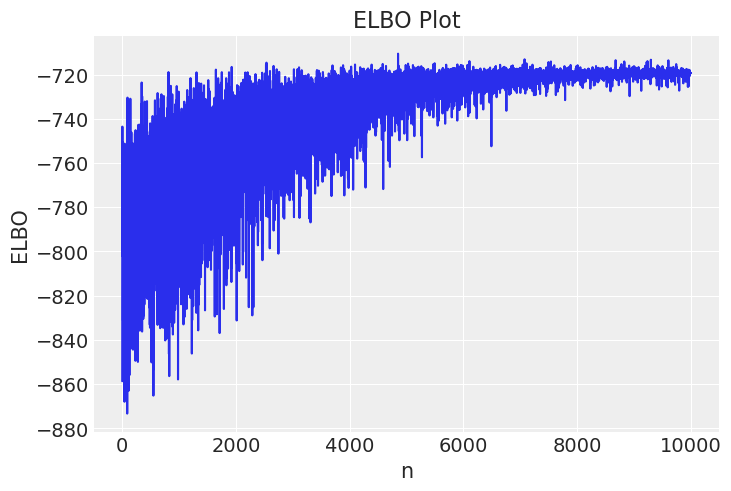

In [43]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO Plot")
plt.show()

#### Trace Plot

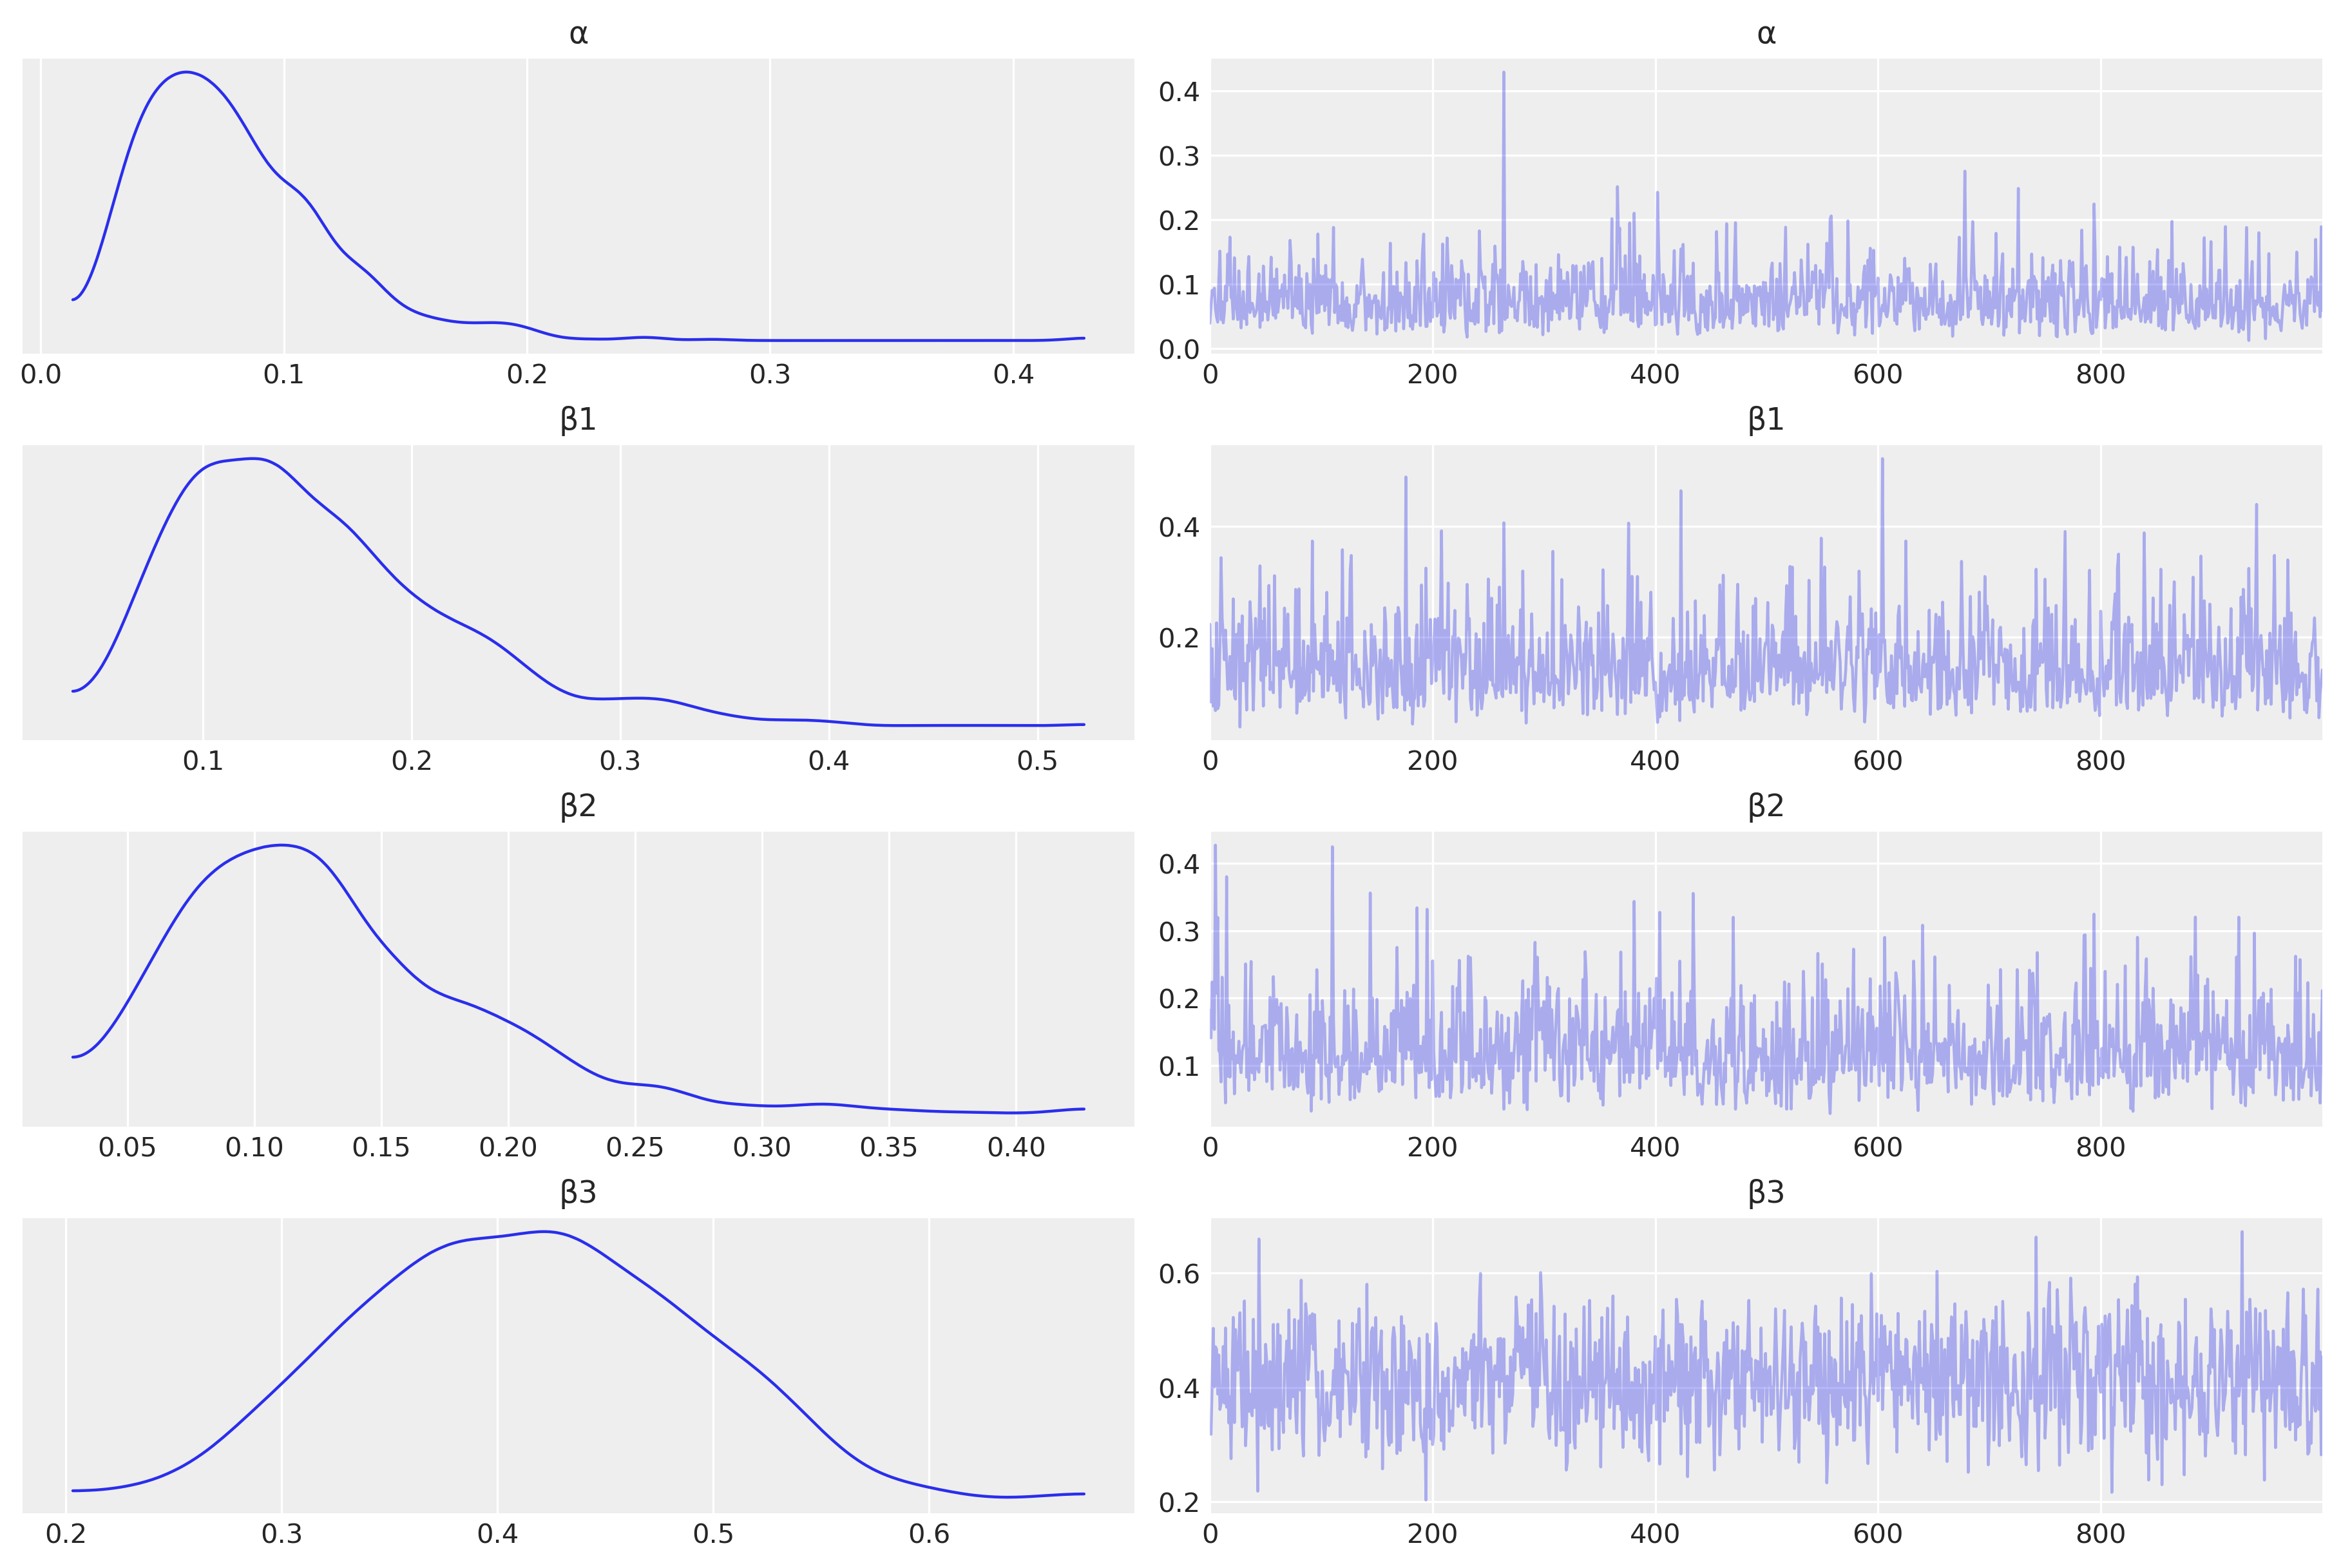

In [44]:
az.plot_trace(advi_trace, compact = False, var_names = ['α','β1','β2', 'β3']);

#### Forest Plot

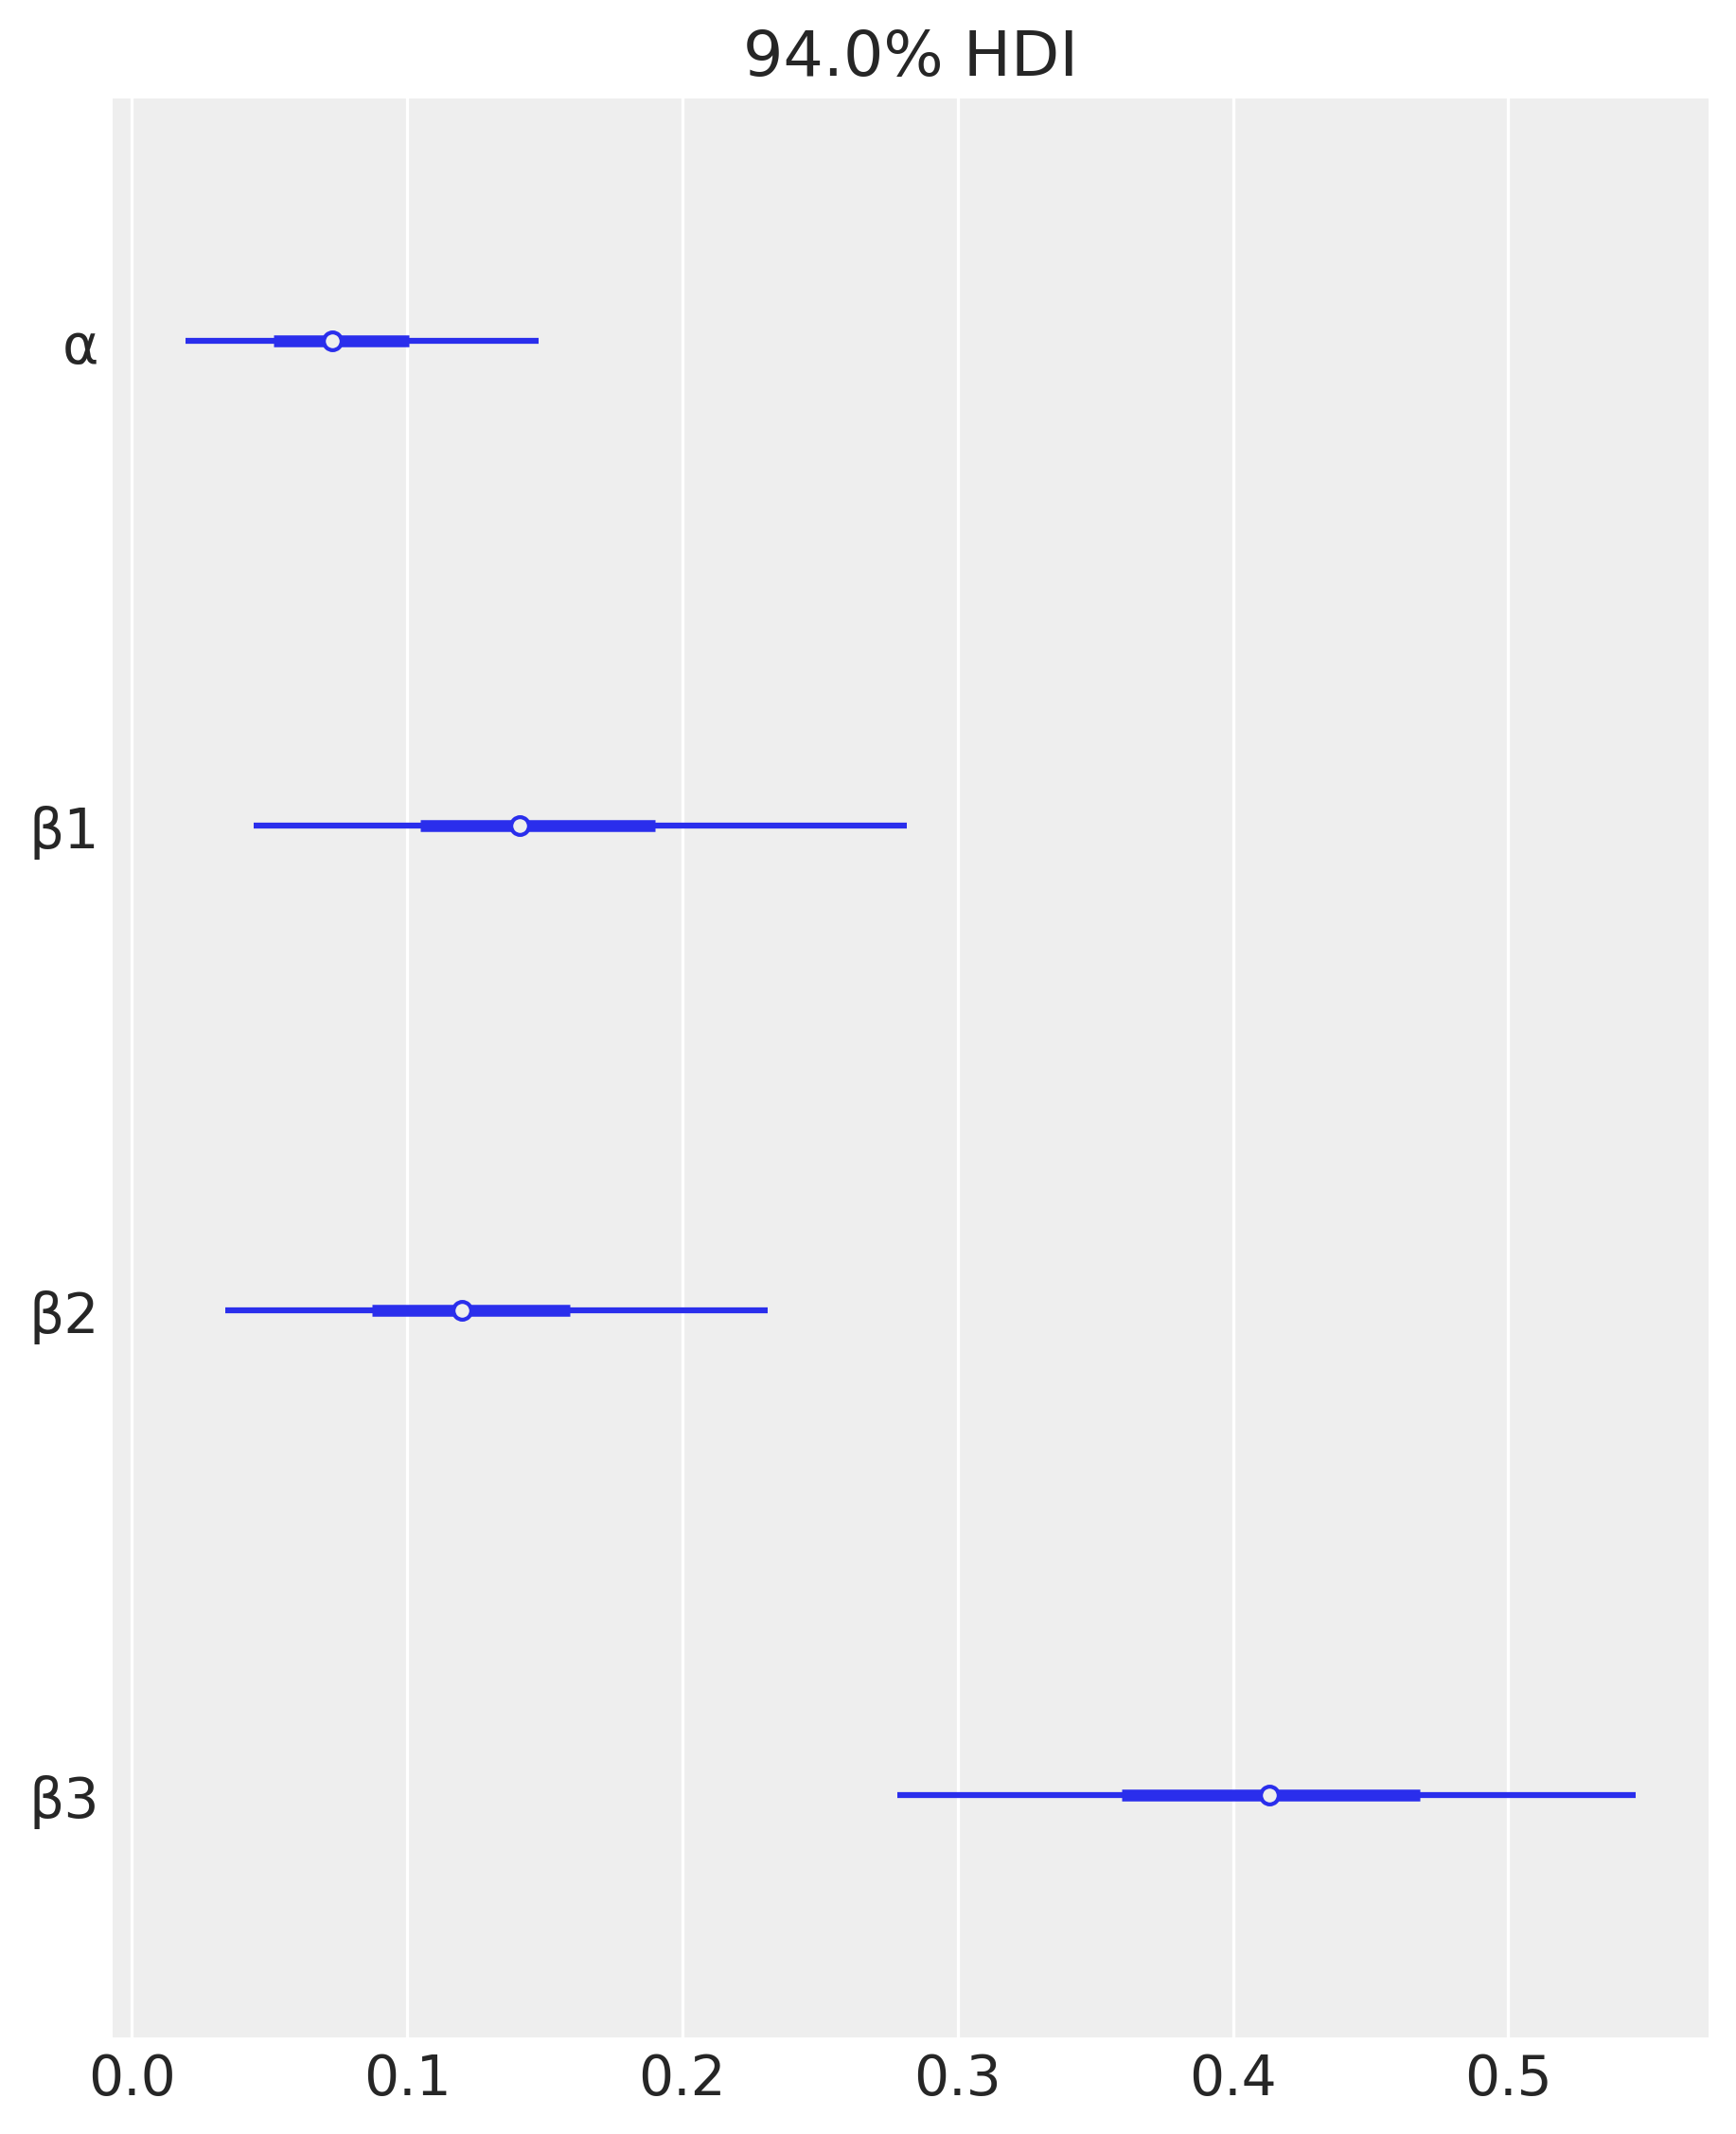

In [45]:
with glm:
    az.plot_forest(advi_trace, var_names=['α',"β1",'β2', 'β3'])

#### Posterior Parameters

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β1'}>,
       <Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β3'}>],
      dtype=object)

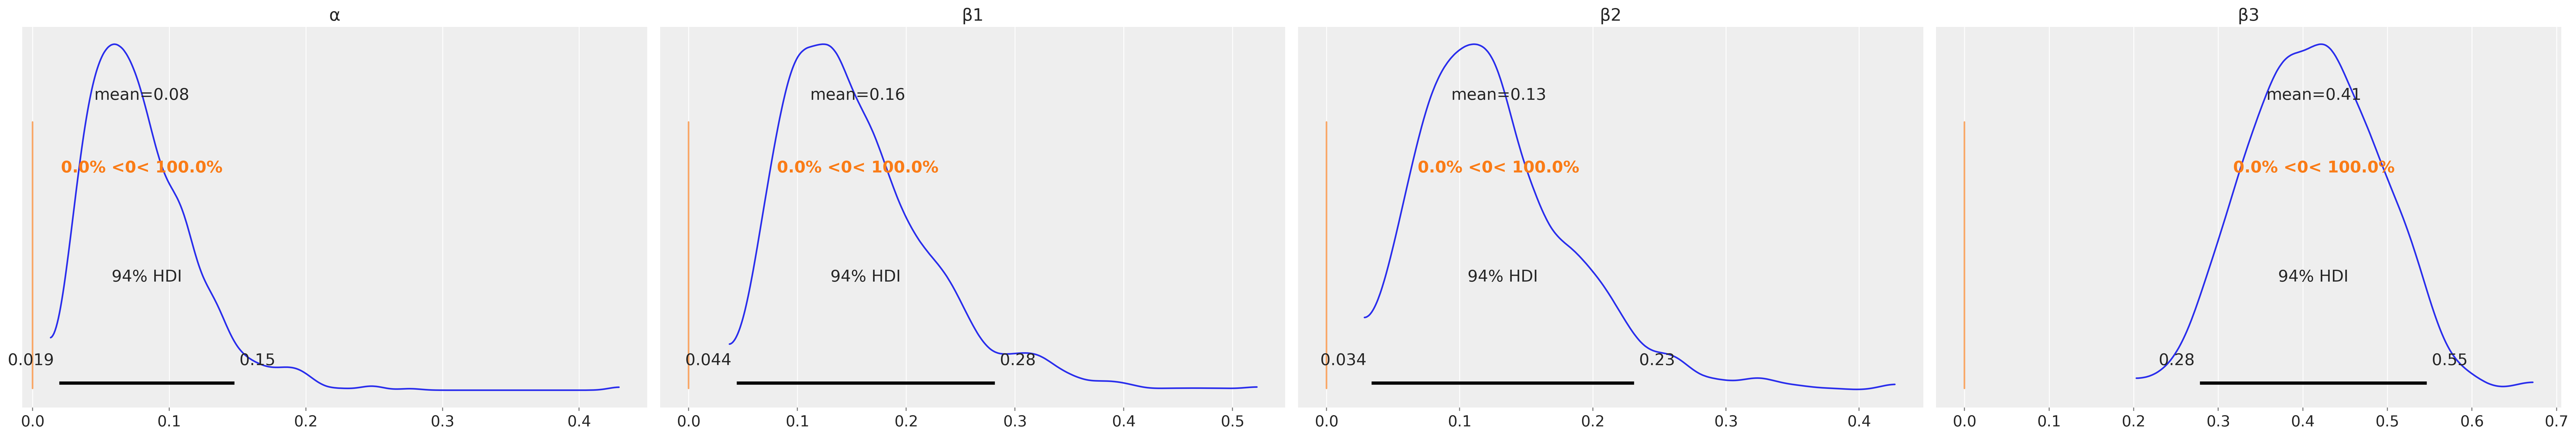

In [46]:
az.plot_posterior(
    advi_trace,
    var_names=['α',"β1",'β2', 'β3'], ref_val = 0
)

#### 95% HDI plot of P(Injury) by Average Exertion

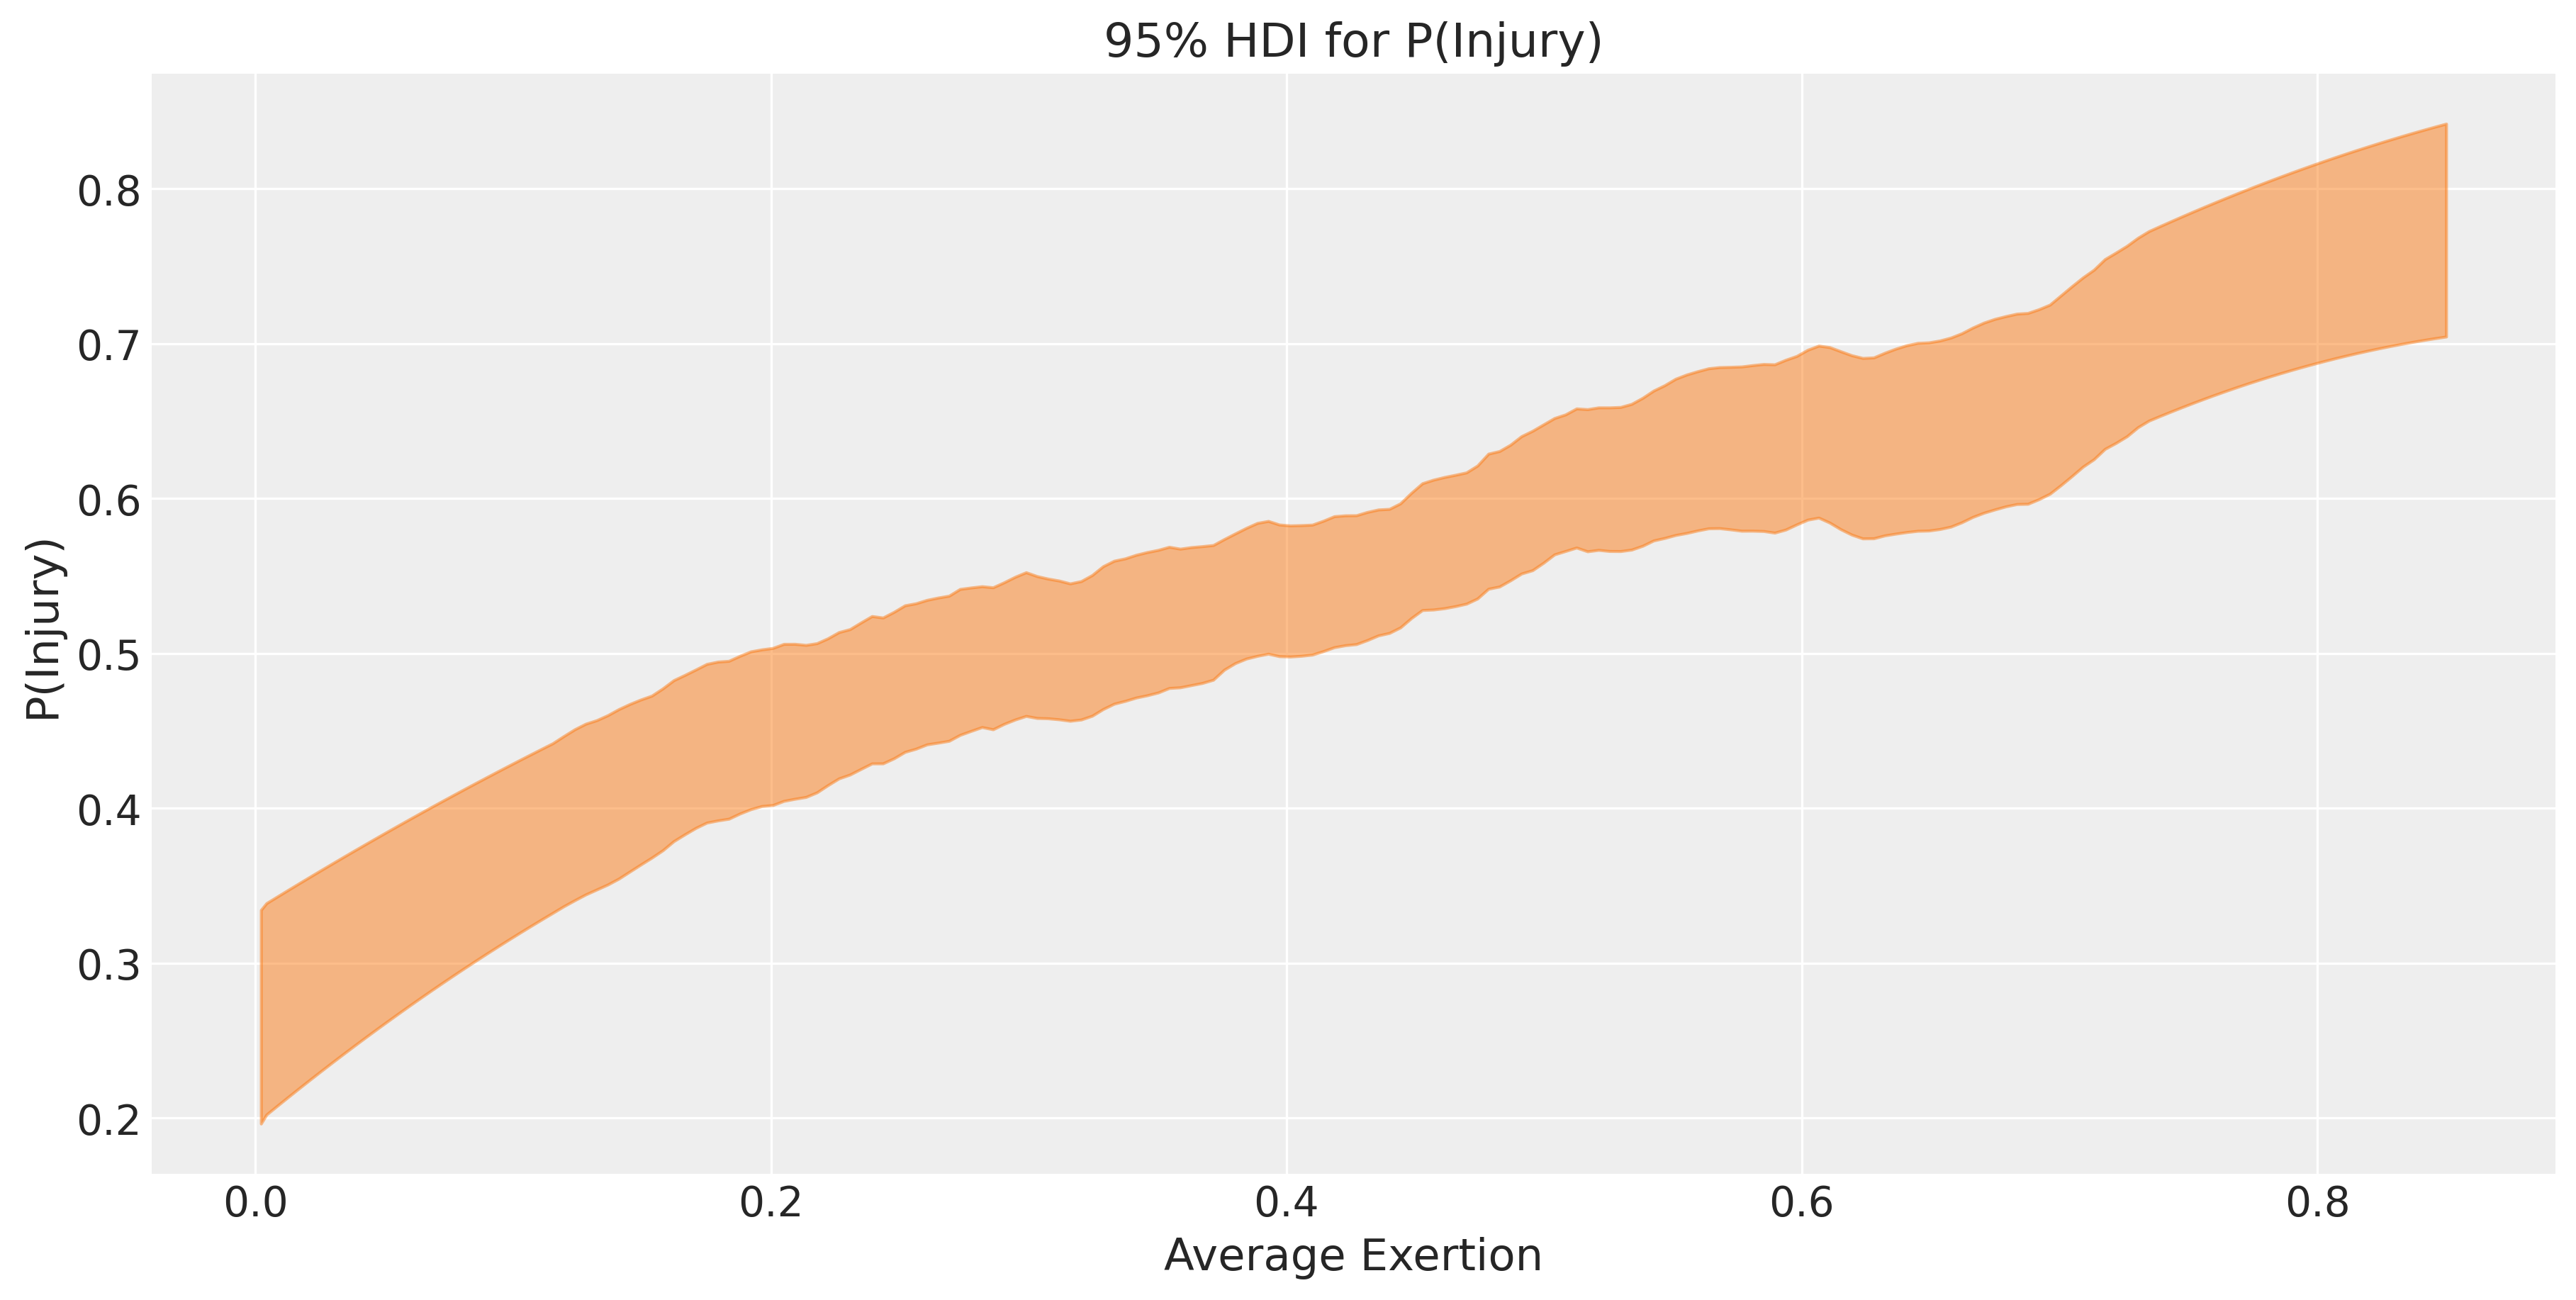

In [47]:
_, ax = plt.subplots(figsize=(12, 6))
rates = advi_trace.posterior["p"]
az.plot_hdi(norm_week["avg_exertion"], rates, smooth=True, hdi_prob=0.95)
rate_mean = advi_trace.posterior["p"].mean(dim=["draw", "chain"])
ax.set_title("95% HDI for P(Injury)")
ax.set_xlabel("Average Exertion")
24
ax.set_ylabel("P(Injury)");

#### Summary

In [48]:
az.summary(advi_trace, var_names = ['α',"β1",'β2', 'β3'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.080  0.040   0.019    0.148      0.001    0.001     901.0     853.0   
β1  0.155  0.069   0.044    0.281      0.002    0.002    1002.0    1026.0   
β2  0.129  0.059   0.034    0.231      0.002    0.001     784.0     954.0   
β3  0.413  0.076   0.278    0.546      0.002    0.002     997.0     981.0   

    r_hat  
α     NaN  
β1    NaN  
β2    NaN  
β3    NaN